# Fine-tuning - Denoising

We will use the pre-trained StorSeismic model to perform a denoising task. The input and output of the network are adjusted to noisy and clean seismic data, respectively.

## Load required modules

In [1]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools

from storseismic.modules import *
from storseismic.train import run_denoising
from storseismic.utils import *

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Fine-tuning configuration

In [2]:
config_path = "./results/pretrain/"
# Allowlist the BertConfig class that appears in the checkpoint
torch.serialization.add_safe_globals([transformers.models.bert.configuration_bert.BertConfig])

config = torch.load(
    os.path.join(config_path, 'config.pt'),
    weights_only=True  # If the file was purely storing module weights
)

# Model Parameter
config.vel_size = 271

# Training Parameter
config.batch_size = 16
config.loss_fn = "l2" # "l2", "ssim", "ssiml1"
config.optim = "radam" # "adam", "radam"
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20

# I/O parameter
config.parent_dir = './results/finetune/denoising/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

print(config)

BertConfig {
  "_attn_implementation_autoset": true,
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 16,
  "classifier_dropout": null,
  "dataset": "./data/finetune/",
  "embedding_type": "none",
  "epoch": 1000,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "loss_fn": "l2",
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_path": "./results/pretrain/",
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "optim": "radam",
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/finetune/denoising/",
  "patience": 20,
  "position_embedding_type": "sincos",


### Load data and wrap in Pytorch DataLoader

In [3]:
!pwd

/home/masa/storseismic


In [4]:
# Allowlist the BertConfig class that appears in the checkpoint
torch.serialization.add_safe_globals([transformers.models.bert.configuration_bert.BertConfig])

# When loading the config
config = torch.load(
    os.path.join(config_path, 'config.pt'),
    weights_only=False  # Trust your own config file
)

# Model Parameter
config.vel_size = 271

# Training Parameter
config.batch_size = 16
config.loss_fn = "l2" # "l2", "ssim", "ssiml1"
config.optim = "radam" # "adam", "radam"
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20

# I/O parameter
config.parent_dir = './results/finetune/denoising/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

print(config)

# When loading the SSDataset
from storseismic.utils import SSDataset
torch.serialization.add_safe_globals([SSDataset])

train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

BertConfig {
  "_attn_implementation_autoset": true,
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 16,
  "classifier_dropout": null,
  "dataset": "./data/finetune/",
  "embedding_type": "none",
  "epoch": 1000,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "loss_fn": "l2",
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_path": "./results/pretrain/",
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "optim": "radam",
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/finetune/denoising/",
  "patience": 20,
  "position_embedding_type": "sincos",


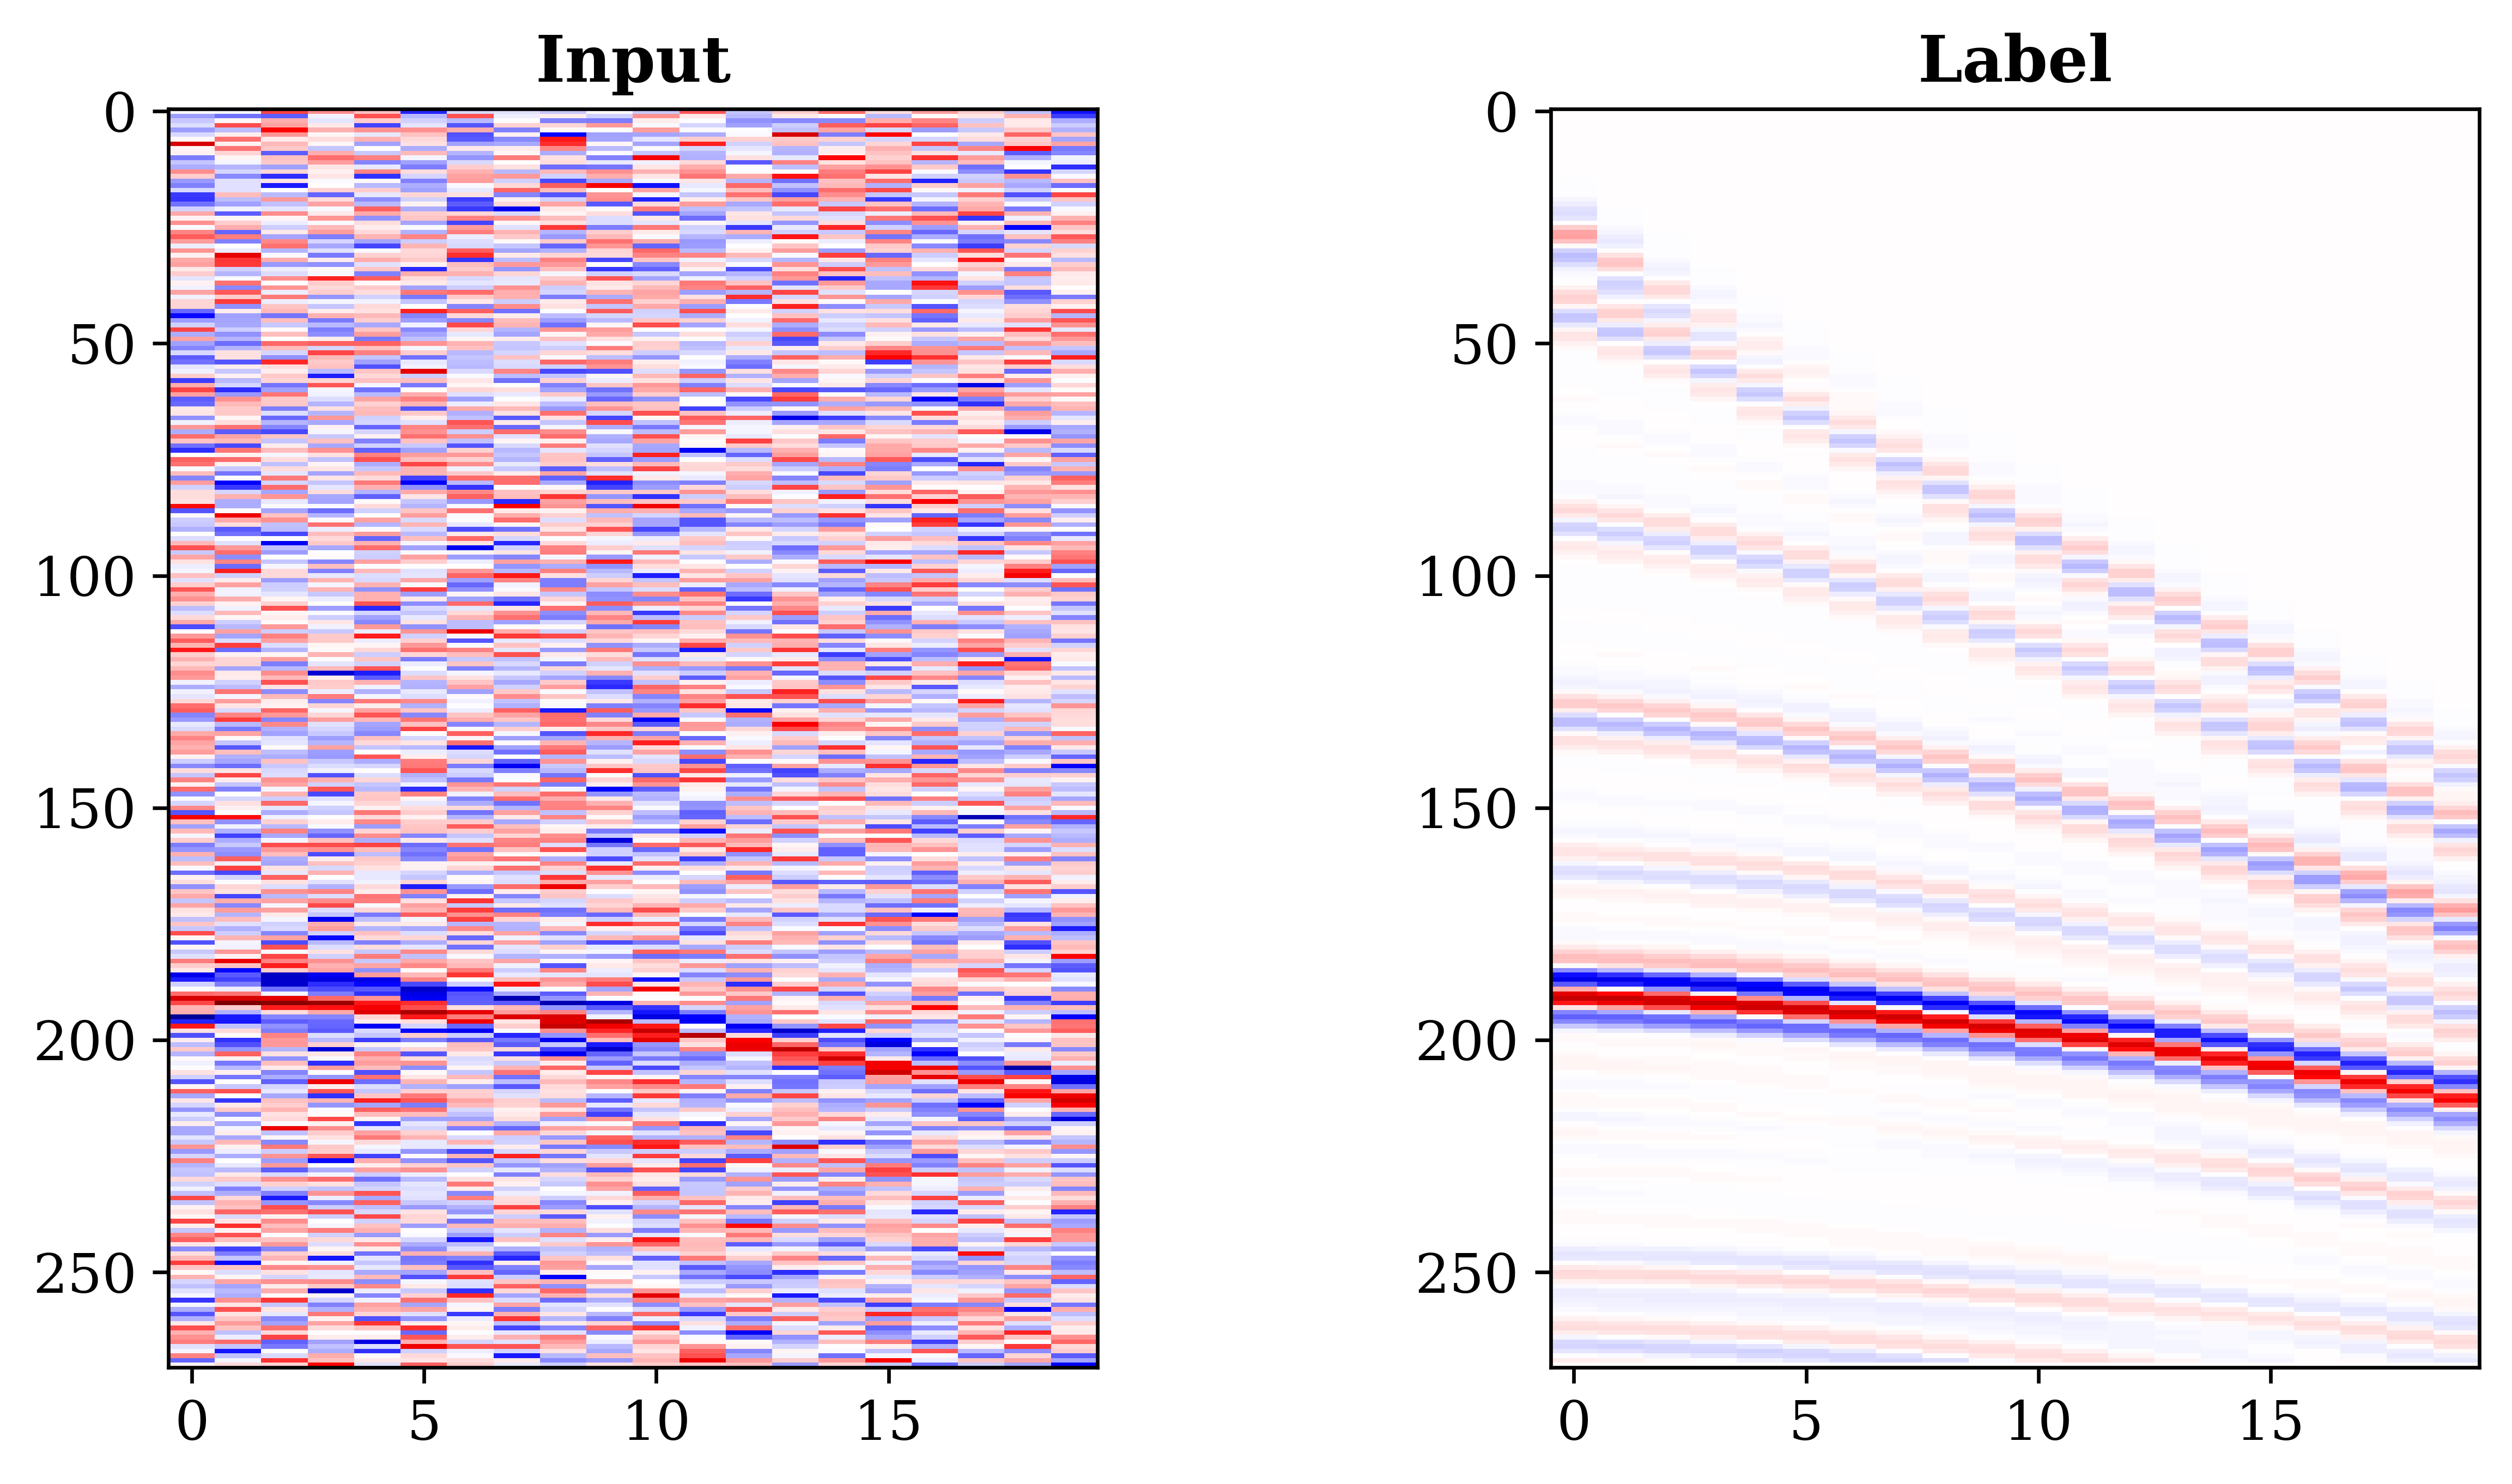

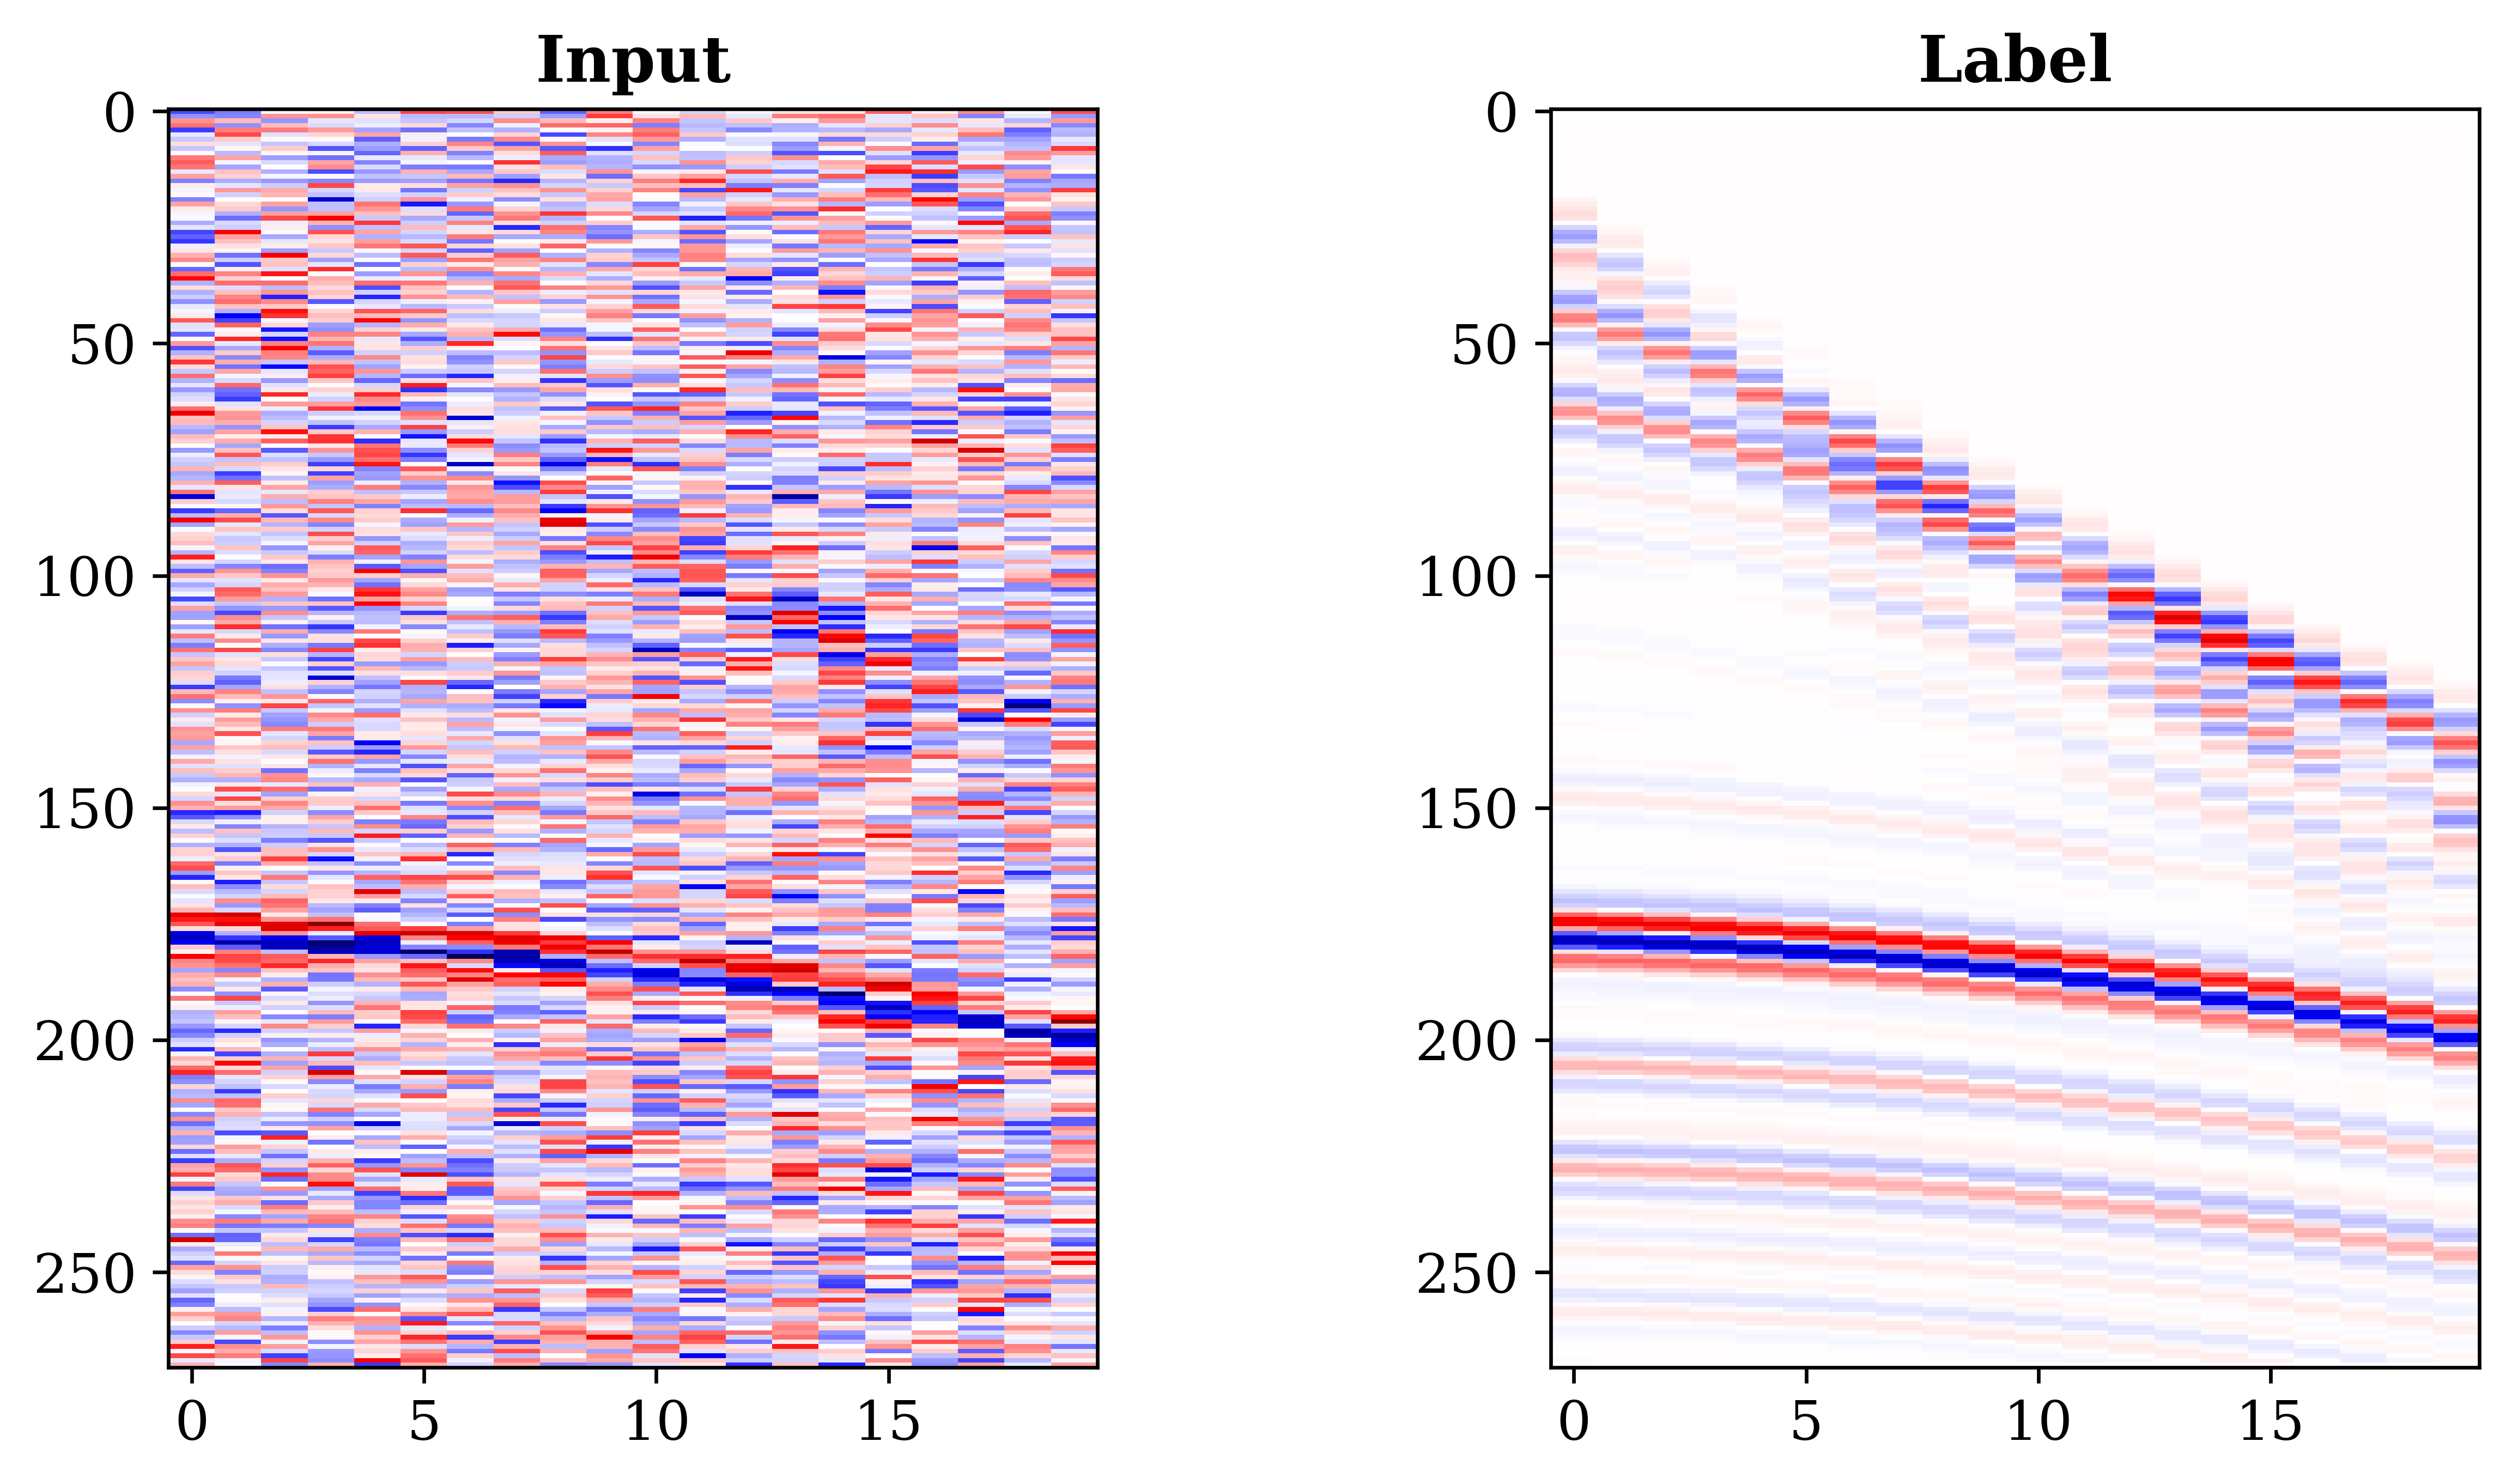

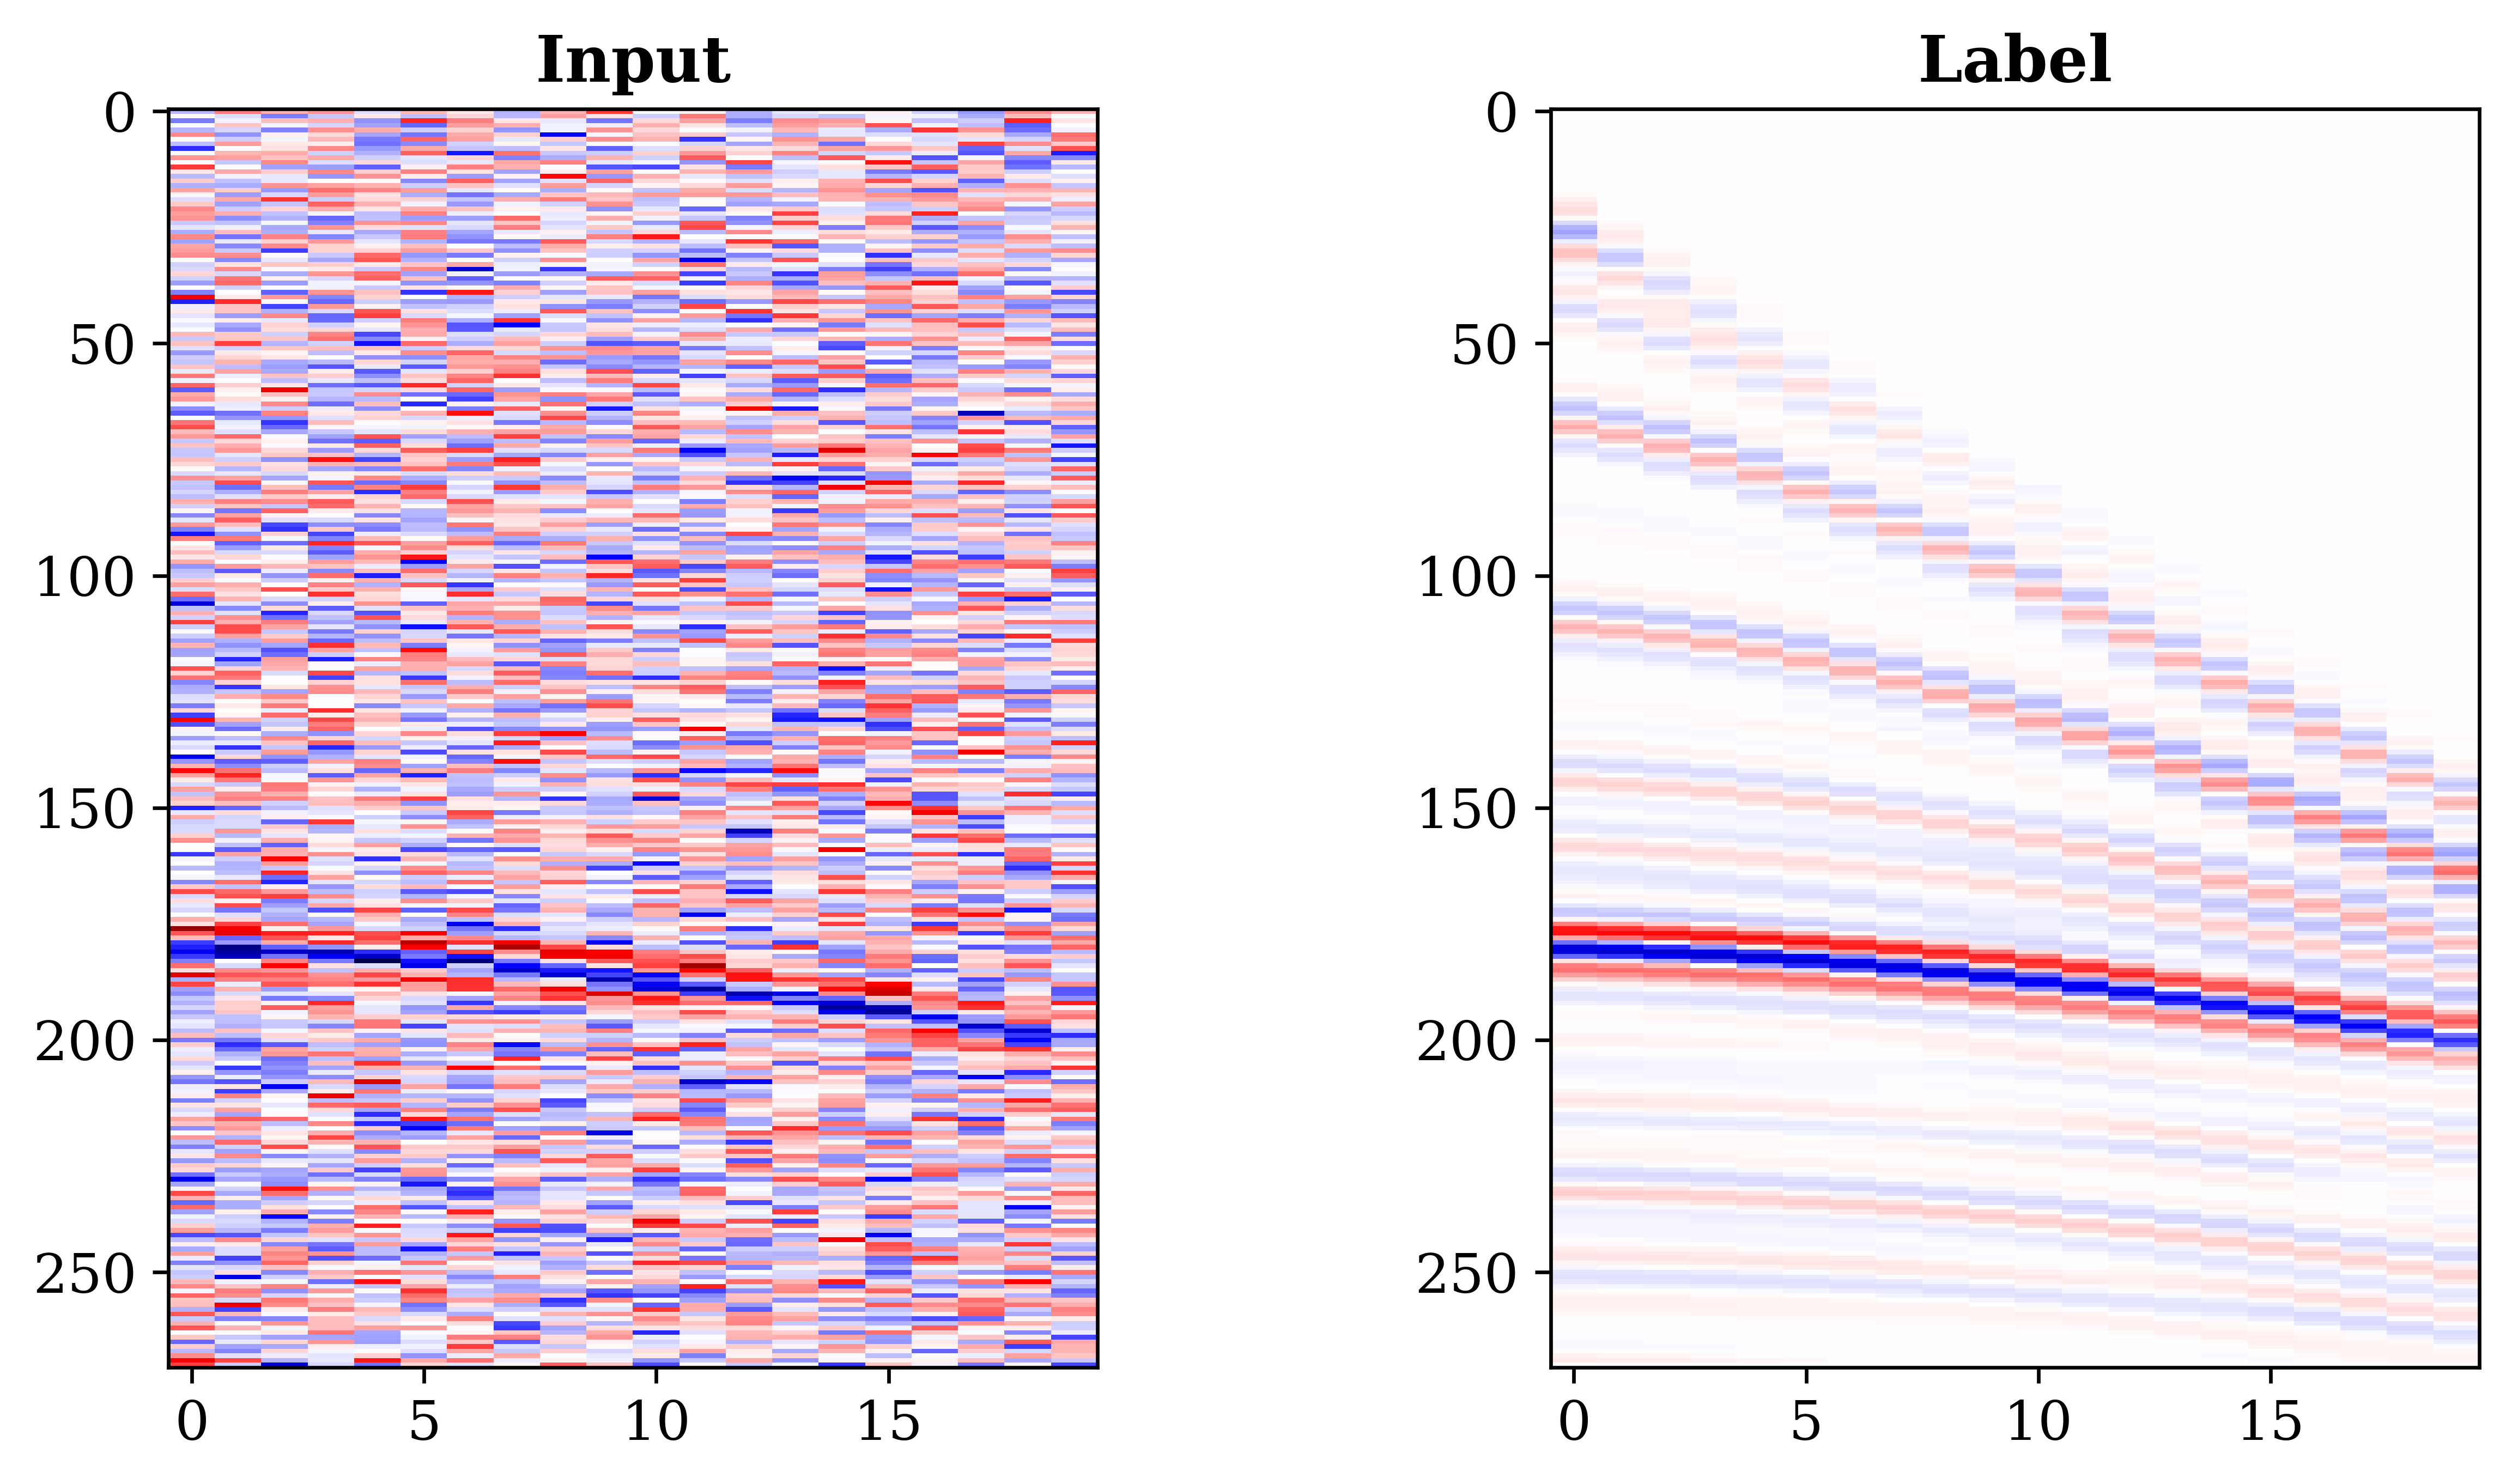

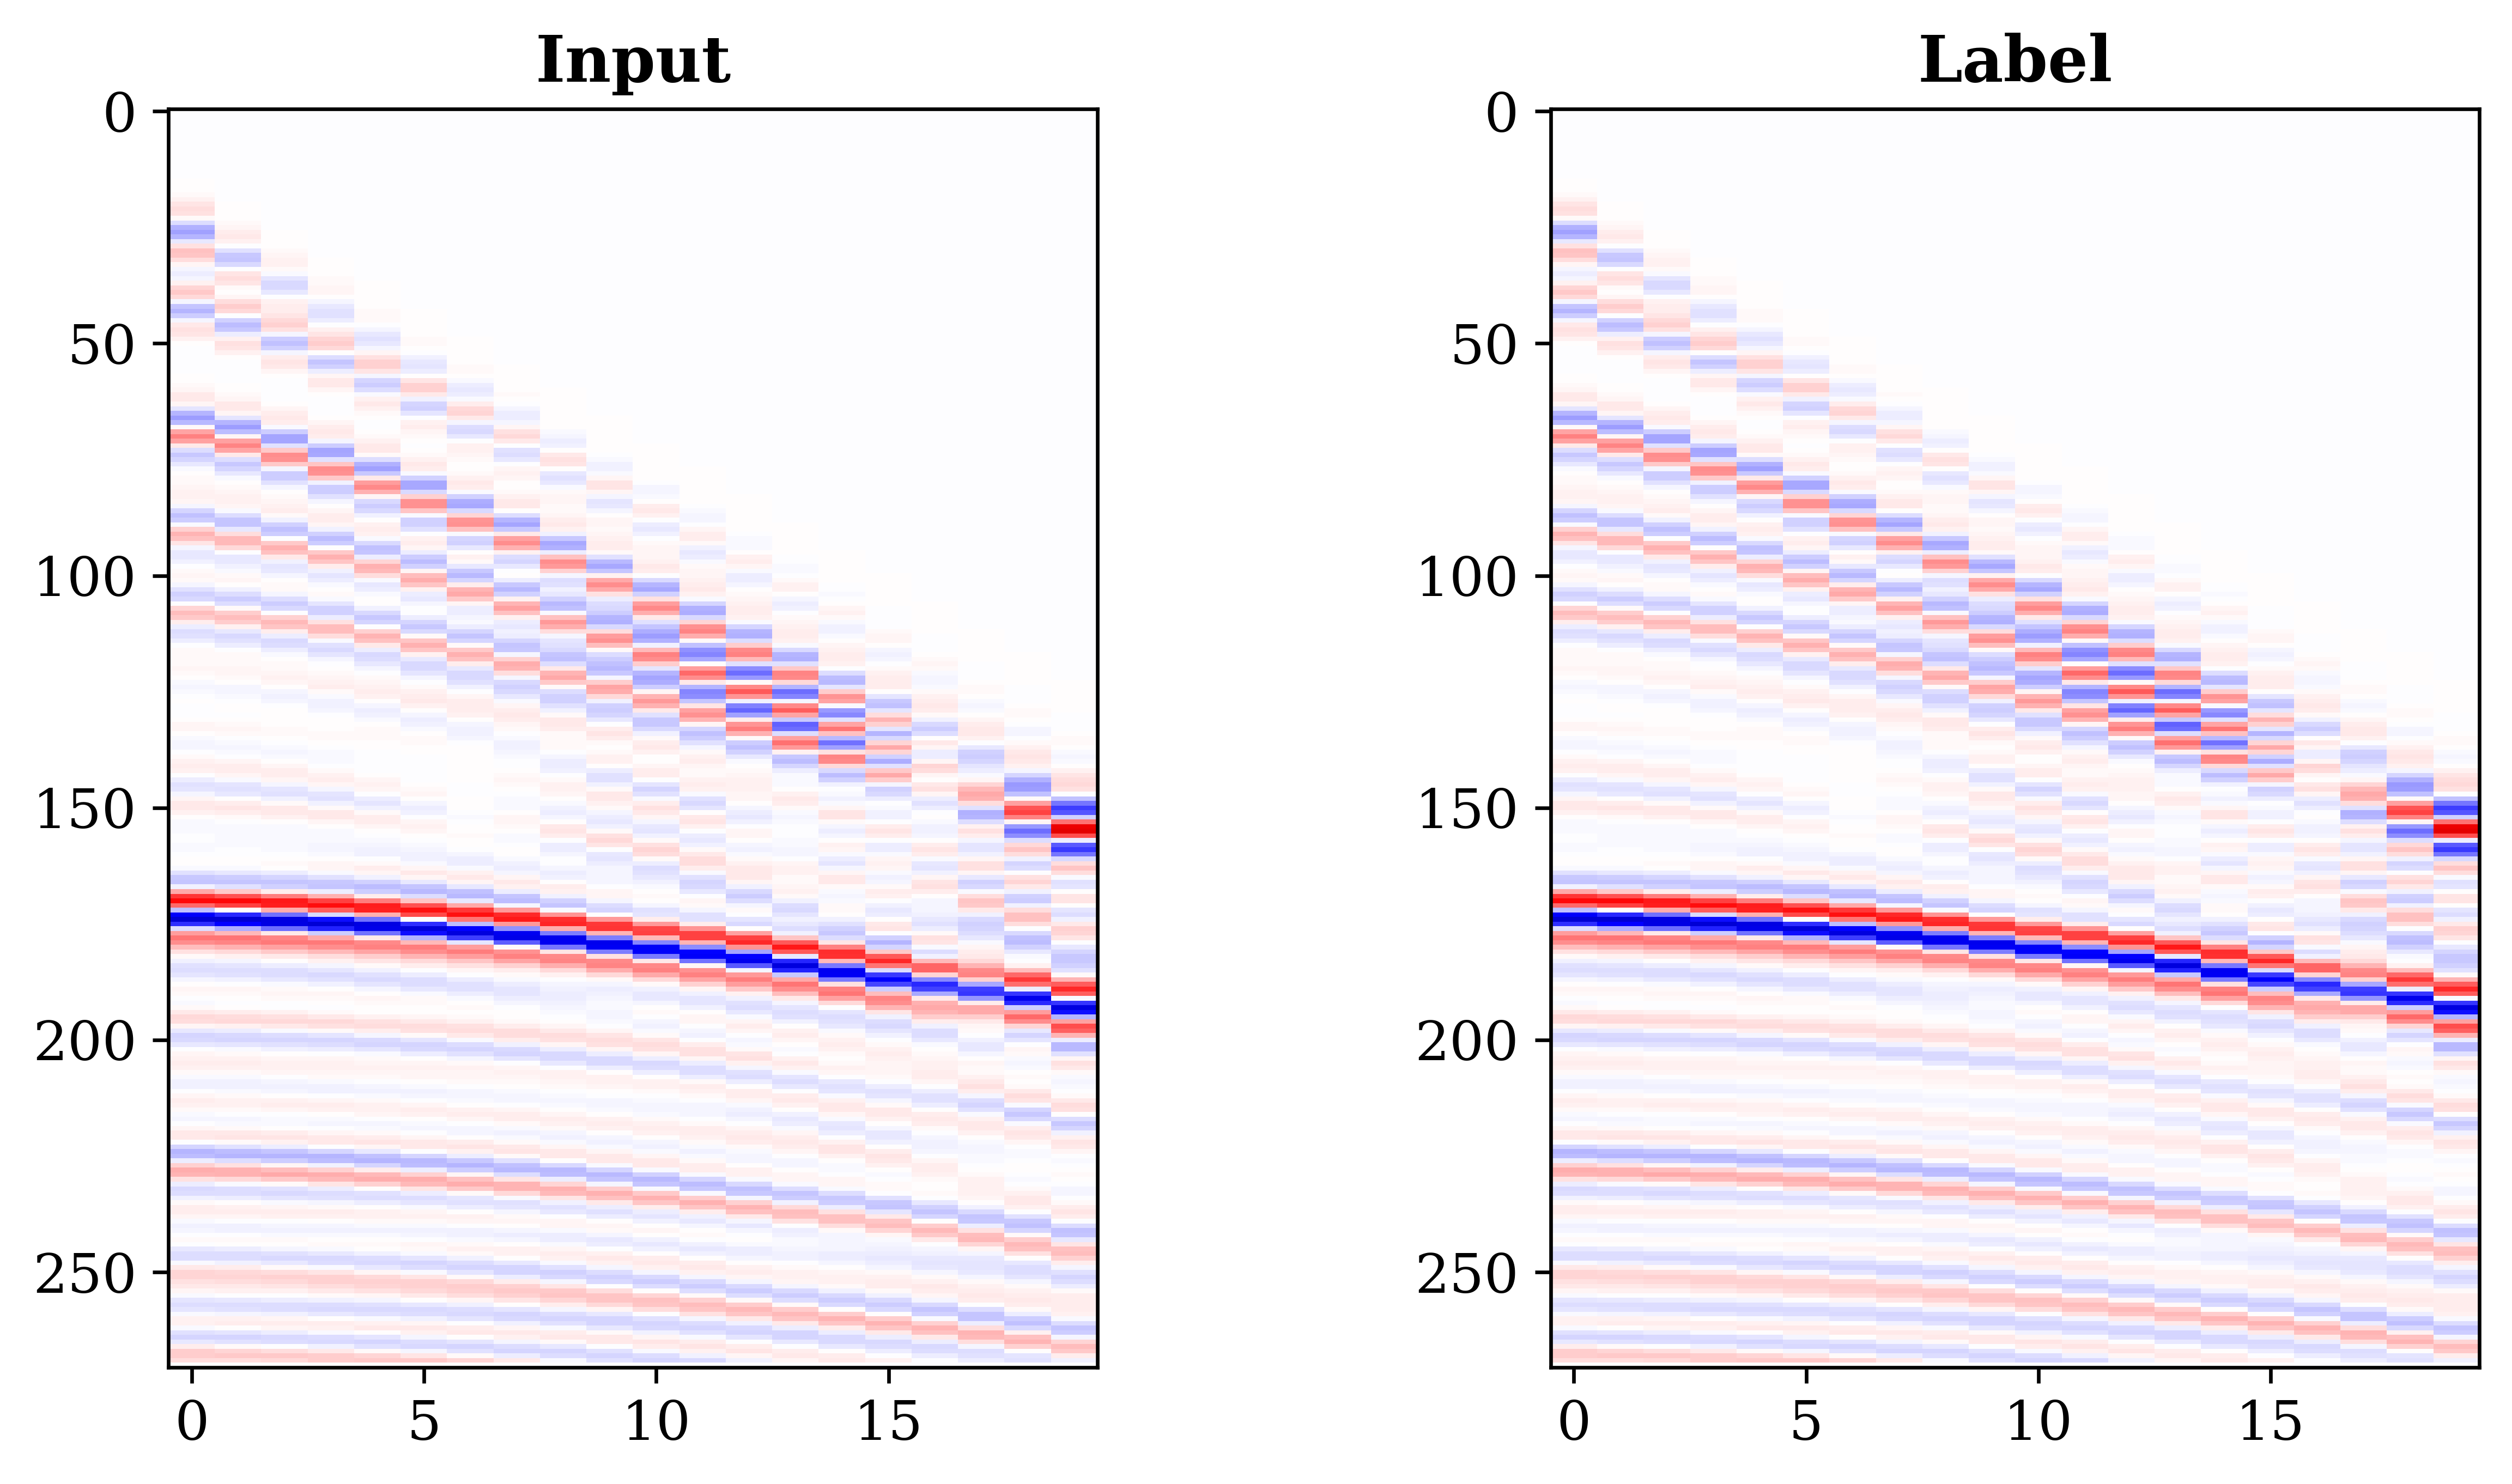

In [5]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].imshow(X['labels'][j, :, :].swapaxes(0, 1) - X['labels'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[1].set_title("Label")

## Setup StorSeismic denoising model

In [6]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Load pre-trained model

In [7]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

In [8]:
model = torch.load(os.path.join(config.model_path, "model.pt"), weights_only=False)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(271, 256, padding_idx=0)
      (position_embeddings): Embedding(20, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=256, out_features=2

### Evaluate zero-shot performance

In [9]:
# After loading the model, but before evaluation
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Correct adapter for input shape [batch_size, seq_len, feature_dim]
class DimensionAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.adapter = nn.Linear(271, 256)
        
    def forward(self, x):
        # Input x shape: [batch_size, seq_len, 271]
        # Return shape: [batch_size, seq_len, 256]
        return self.adapter(x)

# Create and initialize the adapter
input_adapter = DimensionAdapter().to(device)

# Evaluate with adapter
loss_fn = nn.MSELoss(reduction='mean')

loop_valid = tqdm(test_dataloader, leave=True)
losses_valid = 0
with torch.no_grad():
    for i, batch in enumerate(loop_valid):
        inputs_embeds = batch['inputs_embeds'].to(device)
        labels = batch['labels'].to(device)
        
        # Apply dimension adapter (271 -> 256)
        adapted_inputs = input_adapter(inputs_embeds)
        
        # Forward pass with adapted inputs
        outputs = model(inputs_embeds=adapted_inputs)
        
        loss = loss_fn(outputs.logits, labels)
        losses_valid += loss.item()

        loop_valid.set_description(f'Validation 0')
        loop_valid.set_postfix(loss=loss.item())
        
    avg_valid_loss = losses_valid / len(test_dataloader)

print("Zero-shot loss on test data: {}".format(avg_valid_loss))

Validation 0: 100%|██████████| 19/19 [00:00<00:00, 141.58it/s, loss=0.0422]

Zero-shot loss on test data: 0.040946196176503837


### Change the prediction head

In [10]:
model.cls = DenoisingHead(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(271, 256, padding_idx=0)
      (position_embeddings): Embedding(20, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=256, out_features=2

### Check number of trainable parameters

In [11]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.position_embeddings.weight,5120
2,bert.embeddings.token_type_embeddings.weight,512
3,bert.embeddings.LayerNorm.weight,256
4,bert.embeddings.LayerNorm.bias,256
5,bert.encoder.layer.0.attention.LayerNorm.weight,256
6,bert.encoder.layer.0.attention.LayerNorm.bias,256
7,bert.encoder.layer.0.attention.self.query.weight,65536
8,bert.encoder.layer.0.attention.self.query.bias,256
9,bert.encoder.layer.0.attention.self.key.weight,65536


Total Trainable Params: 3304207


3304207

#### Send model to device

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [40]:
# Optimizer
optim = RAdam(model.parameters(), lr=config.lr)

# Loss
loss_fn = nn.MSELoss(reduction='mean')

# Number of epochs
epochs = config.epoch

### Train

In [14]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>

In [15]:
# Define our dimension adapter
class DimensionAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.adapter = nn.Linear(271, 256)
        
    def forward(self, x):
        # Input x shape: [batch_size, seq_len, 271]
        # Return shape: [batch_size, seq_len, 256]
        return self.adapter(x)

# Create the adapter
adapter = DimensionAdapter().to(device)

# Create a wrapper for the model that includes the adapter
class ModelWithAdapter(nn.Module):
    def __init__(self, model, adapter):
        super().__init__()
        self.model = model
        self.adapter = adapter
        
    def forward(self, inputs_embeds=None, **kwargs):
        # Apply the adapter to the inputs
        if inputs_embeds is not None:
            adapted_inputs = self.adapter(inputs_embeds)
            return self.model(inputs_embeds=adapted_inputs, **kwargs)
        return self.model(**kwargs)

# Wrap the model with the adapter
model = ModelWithAdapter(model, adapter).to(device)

# Now the run_denoising function should work correctly
model, avg_train_loss, avg_valid_loss, time_per_epoch = \
run_denoising(model, optim, loss_fn, train_dataloader, test_dataloader, epochs, device, 
              tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax)


  0%|          | 0/75 [00:00<?, ?it/s]/home/masa/miniconda3/envs/storseismic/lib/python3.13/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|██████████| 19/19 [00:00<00:00, 631.84it/s, loss=0.0182]


Epoch time: 0.44 s
Total time elapsed: 0.44 s
---------------------------------------
Validation loss decreased (inf --> 0.018183).  Saving model ...


Validation 1: 100%|██████████| 19/19 [00:00<00:00, 561.86it/s, loss=0.0138]


Epoch time: 0.47 s
Total time elapsed: 0.94 s
---------------------------------------
Validation loss decreased (0.018183 --> 0.013449).  Saving model ...


Validation 2: 100%|██████████| 19/19 [00:00<00:00, 546.75it/s, loss=0.0101]


Epoch time: 0.45 s
Total time elapsed: 1.43 s
---------------------------------------
Validation loss decreased (0.013449 --> 0.011463).  Saving model ...


Validation 3: 100%|██████████| 19/19 [00:00<00:00, 553.02it/s, loss=0.0107]


Epoch time: 0.43 s
Total time elapsed: 1.90 s
---------------------------------------
Validation loss decreased (0.011463 --> 0.010486).  Saving model ...


Validation 4: 100%|██████████| 19/19 [00:00<00:00, 546.28it/s, loss=0.00995]


Epoch time: 0.49 s
Total time elapsed: 2.43 s
---------------------------------------
Validation loss decreased (0.010486 --> 0.009894).  Saving model ...


Validation 5: 100%|██████████| 19/19 [00:00<00:00, 577.81it/s, loss=0.00865]


Epoch time: 0.51 s
Total time elapsed: 2.98 s
---------------------------------------
Validation loss decreased (0.009894 --> 0.009500).  Saving model ...


Validation 6: 100%|██████████| 19/19 [00:00<00:00, 571.97it/s, loss=0.0093]


Epoch time: 0.45 s
Total time elapsed: 3.46 s
---------------------------------------
Validation loss decreased (0.009500 --> 0.009261).  Saving model ...


Validation 7: 100%|██████████| 19/19 [00:00<00:00, 587.79it/s, loss=0.00832]


Epoch time: 0.51 s
Total time elapsed: 4.01 s
---------------------------------------
Validation loss decreased (0.009261 --> 0.008816).  Saving model ...


Validation 8: 100%|██████████| 19/19 [00:00<00:00, 634.19it/s, loss=0.00798]


Epoch time: 0.49 s
Total time elapsed: 4.53 s
---------------------------------------
Validation loss decreased (0.008816 --> 0.008267).  Saving model ...


Validation 9: 100%|██████████| 19/19 [00:00<00:00, 635.15it/s, loss=0.00719]


Epoch time: 0.45 s
Total time elapsed: 5.01 s
---------------------------------------
Validation loss decreased (0.008267 --> 0.007645).  Saving model ...


Validation 10: 100%|██████████| 19/19 [00:00<00:00, 562.29it/s, loss=0.00683]


Epoch time: 0.44 s
Total time elapsed: 5.49 s
---------------------------------------
Validation loss decreased (0.007645 --> 0.007128).  Saving model ...


Validation 11: 100%|██████████| 19/19 [00:00<00:00, 616.74it/s, loss=0.00705]


Epoch time: 0.48 s
Total time elapsed: 6.01 s
---------------------------------------
Validation loss decreased (0.007128 --> 0.006707).  Saving model ...


Validation 12: 100%|██████████| 19/19 [00:00<00:00, 455.44it/s, loss=0.00789]


Epoch time: 0.51 s
Total time elapsed: 6.55 s
---------------------------------------
Validation loss decreased (0.006707 --> 0.006397).  Saving model ...


Validation 13: 100%|██████████| 19/19 [00:00<00:00, 634.52it/s, loss=0.00504]


Epoch time: 0.45 s
Total time elapsed: 7.04 s
---------------------------------------
Validation loss decreased (0.006397 --> 0.006030).  Saving model ...


Validation 14: 100%|██████████| 19/19 [00:00<00:00, 550.29it/s, loss=0.00602]


Epoch time: 0.43 s
Total time elapsed: 7.50 s
---------------------------------------
Validation loss decreased (0.006030 --> 0.005731).  Saving model ...


Validation 15: 100%|██████████| 19/19 [00:00<00:00, 566.07it/s, loss=0.00569]


Epoch time: 0.41 s
Total time elapsed: 7.95 s
---------------------------------------
Validation loss decreased (0.005731 --> 0.005462).  Saving model ...


Validation 16: 100%|██████████| 19/19 [00:00<00:00, 616.06it/s, loss=0.00558]


Epoch time: 0.46 s
Total time elapsed: 8.44 s
---------------------------------------
Validation loss decreased (0.005462 --> 0.005238).  Saving model ...


Validation 17: 100%|██████████| 19/19 [00:00<00:00, 636.73it/s, loss=0.00516]


Epoch time: 0.45 s
Total time elapsed: 8.93 s
---------------------------------------
Validation loss decreased (0.005238 --> 0.005042).  Saving model ...


Validation 18: 100%|██████████| 19/19 [00:00<00:00, 635.61it/s, loss=0.005]


Epoch time: 0.46 s
Total time elapsed: 9.42 s
---------------------------------------
Validation loss decreased (0.005042 --> 0.004831).  Saving model ...


Validation 19: 100%|██████████| 19/19 [00:00<00:00, 601.37it/s, loss=0.00393]


Epoch time: 0.45 s
Total time elapsed: 9.91 s
---------------------------------------
Validation loss decreased (0.004831 --> 0.004680).  Saving model ...


Validation 20: 100%|██████████| 19/19 [00:00<00:00, 563.22it/s, loss=0.00403]


Epoch time: 0.48 s
Total time elapsed: 10.43 s
---------------------------------------
Validation loss decreased (0.004680 --> 0.004512).  Saving model ...


Validation 21: 100%|██████████| 19/19 [00:00<00:00, 645.18it/s, loss=0.00449]


Epoch time: 0.41 s
Total time elapsed: 10.87 s
---------------------------------------
Validation loss decreased (0.004512 --> 0.004396).  Saving model ...


Validation 22: 100%|██████████| 19/19 [00:00<00:00, 574.03it/s, loss=0.00311]


Epoch time: 0.40 s
Total time elapsed: 11.31 s
---------------------------------------
Validation loss decreased (0.004396 --> 0.004253).  Saving model ...


Validation 23: 100%|██████████| 19/19 [00:00<00:00, 556.46it/s, loss=0.00409]


Epoch time: 0.44 s
Total time elapsed: 11.79 s
---------------------------------------
Validation loss decreased (0.004253 --> 0.004164).  Saving model ...


Validation 24: 100%|██████████| 19/19 [00:00<00:00, 554.71it/s, loss=0.00357]


Epoch time: 0.46 s
Total time elapsed: 12.29 s
---------------------------------------
Validation loss decreased (0.004164 --> 0.004064).  Saving model ...


Validation 25: 100%|██████████| 19/19 [00:00<00:00, 559.14it/s, loss=0.00518]


Epoch time: 0.44 s
Total time elapsed: 12.77 s
---------------------------------------
Validation loss decreased (0.004064 --> 0.004028).  Saving model ...


Validation 26: 100%|██████████| 19/19 [00:00<00:00, 584.65it/s, loss=0.00274]


Epoch time: 0.42 s
Total time elapsed: 13.24 s
---------------------------------------
Validation loss decreased (0.004028 --> 0.003925).  Saving model ...


Validation 27: 100%|██████████| 19/19 [00:00<00:00, 607.01it/s, loss=0.004]


Epoch time: 0.46 s
Total time elapsed: 13.73 s
---------------------------------------
Validation loss decreased (0.003925 --> 0.003908).  Saving model ...


Validation 28: 100%|██████████| 19/19 [00:00<00:00, 630.85it/s, loss=0.00375]


Epoch time: 0.42 s
Total time elapsed: 14.19 s
---------------------------------------
Validation loss decreased (0.003908 --> 0.003829).  Saving model ...


Validation 29: 100%|██████████| 19/19 [00:00<00:00, 617.90it/s, loss=0.00429]


Epoch time: 0.45 s
Total time elapsed: 14.67 s
---------------------------------------
Validation loss decreased (0.003829 --> 0.003777).  Saving model ...


Validation 30: 100%|██████████| 19/19 [00:00<00:00, 637.71it/s, loss=0.00415]


Epoch time: 0.43 s
Total time elapsed: 15.14 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 31: 100%|██████████| 19/19 [00:00<00:00, 563.40it/s, loss=0.00448]


Epoch time: 0.44 s
Total time elapsed: 15.60 s
---------------------------------------
Validation loss decreased (0.003777 --> 0.003697).  Saving model ...


Validation 32: 100%|██████████| 19/19 [00:00<00:00, 564.91it/s, loss=0.00378]


Epoch time: 0.42 s
Total time elapsed: 16.05 s
---------------------------------------
Validation loss decreased (0.003697 --> 0.003636).  Saving model ...


Validation 33: 100%|██████████| 19/19 [00:00<00:00, 565.32it/s, loss=0.00359]


Epoch time: 0.44 s
Total time elapsed: 16.53 s
---------------------------------------
Validation loss decreased (0.003636 --> 0.003614).  Saving model ...


Validation 34: 100%|██████████| 19/19 [00:00<00:00, 609.79it/s, loss=0.00321]


Epoch time: 0.43 s
Total time elapsed: 17.00 s
---------------------------------------
Validation loss decreased (0.003614 --> 0.003546).  Saving model ...


Validation 35: 100%|██████████| 19/19 [00:00<00:00, 600.79it/s, loss=0.00375]


Epoch time: 0.42 s
Total time elapsed: 17.63 s
---------------------------------------
Validation loss decreased (0.003546 --> 0.003521).  Saving model ...


Validation 36: 100%|██████████| 19/19 [00:00<00:00, 621.98it/s, loss=0.00369]


Epoch time: 0.42 s
Total time elapsed: 18.09 s
---------------------------------------
Validation loss decreased (0.003521 --> 0.003471).  Saving model ...


Validation 37: 100%|██████████| 19/19 [00:00<00:00, 543.58it/s, loss=0.00387]


Epoch time: 0.46 s
Total time elapsed: 18.60 s
---------------------------------------
Validation loss decreased (0.003471 --> 0.003451).  Saving model ...


Validation 38: 100%|██████████| 19/19 [00:00<00:00, 563.99it/s, loss=0.00382]


Epoch time: 0.44 s
Total time elapsed: 19.07 s
---------------------------------------
Validation loss decreased (0.003451 --> 0.003431).  Saving model ...


Validation 39: 100%|██████████| 19/19 [00:00<00:00, 559.43it/s, loss=0.00283]


Epoch time: 0.50 s
Total time elapsed: 19.62 s
---------------------------------------
Validation loss decreased (0.003431 --> 0.003405).  Saving model ...


Validation 40: 100%|██████████| 19/19 [00:00<00:00, 592.91it/s, loss=0.00309]


Epoch time: 0.50 s
Total time elapsed: 20.15 s
---------------------------------------
Validation loss decreased (0.003405 --> 0.003360).  Saving model ...


Validation 41: 100%|██████████| 19/19 [00:00<00:00, 600.69it/s, loss=0.00299]


Epoch time: 0.50 s
Total time elapsed: 20.69 s
---------------------------------------
Validation loss decreased (0.003360 --> 0.003350).  Saving model ...


Validation 42: 100%|██████████| 19/19 [00:00<00:00, 627.42it/s, loss=0.00321]


Epoch time: 0.47 s
Total time elapsed: 21.19 s
---------------------------------------
Validation loss decreased (0.003350 --> 0.003320).  Saving model ...


Validation 43: 100%|██████████| 19/19 [00:00<00:00, 438.20it/s, loss=0.00338]


Epoch time: 0.42 s
Total time elapsed: 21.65 s
---------------------------------------
Validation loss decreased (0.003320 --> 0.003303).  Saving model ...


Validation 44: 100%|██████████| 19/19 [00:00<00:00, 515.90it/s, loss=0.00278]


Epoch time: 0.48 s
Total time elapsed: 22.17 s
---------------------------------------
Validation loss decreased (0.003303 --> 0.003264).  Saving model ...


Validation 45: 100%|██████████| 19/19 [00:00<00:00, 589.49it/s, loss=0.00299]


Epoch time: 0.47 s
Total time elapsed: 22.69 s
---------------------------------------
Validation loss decreased (0.003264 --> 0.003208).  Saving model ...


Validation 46: 100%|██████████| 19/19 [00:00<00:00, 620.65it/s, loss=0.00278]


Epoch time: 0.51 s
Total time elapsed: 23.23 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 47: 100%|██████████| 19/19 [00:00<00:00, 565.91it/s, loss=0.00357]


Epoch time: 0.48 s
Total time elapsed: 23.74 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 48: 100%|██████████| 19/19 [00:00<00:00, 603.81it/s, loss=0.00347]


Epoch time: 0.45 s
Total time elapsed: 24.21 s
---------------------------------------
Validation loss decreased (0.003208 --> 0.003183).  Saving model ...


Validation 49: 100%|██████████| 19/19 [00:00<00:00, 619.87it/s, loss=0.00316]


Epoch time: 0.42 s
Total time elapsed: 24.66 s
---------------------------------------
Validation loss decreased (0.003183 --> 0.003165).  Saving model ...


Validation 50: 100%|██████████| 19/19 [00:00<00:00, 569.34it/s, loss=0.00325]


Epoch time: 0.42 s
Total time elapsed: 25.12 s
---------------------------------------
Validation loss decreased (0.003165 --> 0.003099).  Saving model ...


Validation 51: 100%|██████████| 19/19 [00:00<00:00, 575.26it/s, loss=0.00321]


Epoch time: 0.46 s
Total time elapsed: 25.62 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 52: 100%|██████████| 19/19 [00:00<00:00, 629.97it/s, loss=0.00332]


Epoch time: 0.44 s
Total time elapsed: 26.08 s
---------------------------------------
Validation loss decreased (0.003099 --> 0.003072).  Saving model ...


Validation 53: 100%|██████████| 19/19 [00:00<00:00, 566.48it/s, loss=0.00282]


Epoch time: 0.44 s
Total time elapsed: 26.56 s
---------------------------------------
Validation loss decreased (0.003072 --> 0.003028).  Saving model ...


Validation 54: 100%|██████████| 19/19 [00:00<00:00, 545.02it/s, loss=0.00275]


Epoch time: 0.45 s
Total time elapsed: 27.05 s
---------------------------------------
Validation loss decreased (0.003028 --> 0.003022).  Saving model ...


Validation 55: 100%|██████████| 19/19 [00:00<00:00, 532.72it/s, loss=0.00207]


Epoch time: 0.45 s
Total time elapsed: 27.54 s
---------------------------------------
Validation loss decreased (0.003022 --> 0.002980).  Saving model ...


Validation 56: 100%|██████████| 19/19 [00:00<00:00, 634.26it/s, loss=0.00351]


Epoch time: 0.46 s
Total time elapsed: 28.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 57: 100%|██████████| 19/19 [00:00<00:00, 580.40it/s, loss=0.00201]


Epoch time: 0.47 s
Total time elapsed: 28.54 s
---------------------------------------
Validation loss decreased (0.002980 --> 0.002915).  Saving model ...


Validation 58: 100%|██████████| 19/19 [00:00<00:00, 578.37it/s, loss=0.00325]


Epoch time: 0.50 s
Total time elapsed: 29.07 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 59: 100%|██████████| 19/19 [00:00<00:00, 481.00it/s, loss=0.00279]


Epoch time: 0.43 s
Total time elapsed: 29.53 s
---------------------------------------
Validation loss decreased (0.002915 --> 0.002902).  Saving model ...


Validation 60: 100%|██████████| 19/19 [00:00<00:00, 616.67it/s, loss=0.00236]


Epoch time: 0.41 s
Total time elapsed: 29.98 s
---------------------------------------
Validation loss decreased (0.002902 --> 0.002860).  Saving model ...


Validation 61: 100%|██████████| 19/19 [00:00<00:00, 619.69it/s, loss=0.00273]


Epoch time: 0.45 s
Total time elapsed: 30.46 s
---------------------------------------
Validation loss decreased (0.002860 --> 0.002817).  Saving model ...


Validation 62: 100%|██████████| 19/19 [00:00<00:00, 504.71it/s, loss=0.00261]


Epoch time: 0.45 s
Total time elapsed: 30.95 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 63: 100%|██████████| 19/19 [00:00<00:00, 604.60it/s, loss=0.00278]


Epoch time: 0.42 s
Total time elapsed: 31.39 s
---------------------------------------
Validation loss decreased (0.002817 --> 0.002791).  Saving model ...


Validation 64: 100%|██████████| 19/19 [00:00<00:00, 612.47it/s, loss=0.00214]


Epoch time: 0.42 s
Total time elapsed: 31.85 s
---------------------------------------
Validation loss decreased (0.002791 --> 0.002760).  Saving model ...


Validation 65: 100%|██████████| 19/19 [00:00<00:00, 559.19it/s, loss=0.00331]


Epoch time: 0.44 s
Total time elapsed: 32.32 s
---------------------------------------
Validation loss decreased (0.002760 --> 0.002727).  Saving model ...


Validation 66: 100%|██████████| 19/19 [00:00<00:00, 355.60it/s, loss=0.00296]


Epoch time: 0.47 s
Total time elapsed: 32.83 s
---------------------------------------
Validation loss decreased (0.002727 --> 0.002707).  Saving model ...


Validation 67: 100%|██████████| 19/19 [00:00<00:00, 622.78it/s, loss=0.00305]


Epoch time: 0.49 s
Total time elapsed: 33.35 s
---------------------------------------
Validation loss decreased (0.002707 --> 0.002701).  Saving model ...


Validation 68: 100%|██████████| 19/19 [00:00<00:00, 594.56it/s, loss=0.00297]


Epoch time: 0.45 s
Total time elapsed: 33.84 s
---------------------------------------
Validation loss decreased (0.002701 --> 0.002624).  Saving model ...


Validation 69: 100%|██████████| 19/19 [00:00<00:00, 634.60it/s, loss=0.00294]


Epoch time: 0.43 s
Total time elapsed: 34.31 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 70: 100%|██████████| 19/19 [00:00<00:00, 602.25it/s, loss=0.00244]


Epoch time: 0.44 s
Total time elapsed: 34.78 s
---------------------------------------
Validation loss decreased (0.002624 --> 0.002598).  Saving model ...


Validation 71: 100%|██████████| 19/19 [00:00<00:00, 600.04it/s, loss=0.00204]


Epoch time: 0.44 s
Total time elapsed: 35.26 s
---------------------------------------
Validation loss decreased (0.002598 --> 0.002557).  Saving model ...


Validation 72: 100%|██████████| 19/19 [00:00<00:00, 553.11it/s, loss=0.00296]


Epoch time: 0.45 s
Total time elapsed: 35.75 s
---------------------------------------
Validation loss decreased (0.002557 --> 0.002541).  Saving model ...


Validation 73: 100%|██████████| 19/19 [00:00<00:00, 553.68it/s, loss=0.00214]


Epoch time: 0.53 s
Total time elapsed: 36.31 s
---------------------------------------
Validation loss decreased (0.002541 --> 0.002503).  Saving model ...


Validation 74: 100%|██████████| 19/19 [00:00<00:00, 557.18it/s, loss=0.00295]


Epoch time: 0.56 s
Total time elapsed: 36.91 s
---------------------------------------
Validation loss decreased (0.002503 --> 0.002457).  Saving model ...


Validation 75: 100%|██████████| 19/19 [00:00<00:00, 598.40it/s, loss=0.00266]


Epoch time: 0.49 s
Total time elapsed: 37.43 s
---------------------------------------
Validation loss decreased (0.002457 --> 0.002428).  Saving model ...


Validation 76: 100%|██████████| 19/19 [00:00<00:00, 634.52it/s, loss=0.00232]


Epoch time: 0.46 s
Total time elapsed: 37.93 s
---------------------------------------
Validation loss decreased (0.002428 --> 0.002394).  Saving model ...


Validation 77: 100%|██████████| 19/19 [00:00<00:00, 574.28it/s, loss=0.00186]


Epoch time: 0.47 s
Total time elapsed: 38.43 s
---------------------------------------
Validation loss decreased (0.002394 --> 0.002361).  Saving model ...


Validation 78: 100%|██████████| 19/19 [00:00<00:00, 561.93it/s, loss=0.00251]


Epoch time: 0.48 s
Total time elapsed: 38.95 s
---------------------------------------
Validation loss decreased (0.002361 --> 0.002341).  Saving model ...


Validation 79: 100%|██████████| 19/19 [00:00<00:00, 575.89it/s, loss=0.0025]


Epoch time: 0.48 s
Total time elapsed: 39.48 s
---------------------------------------
Validation loss decreased (0.002341 --> 0.002336).  Saving model ...


Validation 80: 100%|██████████| 19/19 [00:00<00:00, 587.18it/s, loss=0.00209]


Epoch time: 0.47 s
Total time elapsed: 39.99 s
---------------------------------------
Validation loss decreased (0.002336 --> 0.002295).  Saving model ...


Validation 81: 100%|██████████| 19/19 [00:00<00:00, 523.43it/s, loss=0.00232]


Epoch time: 0.47 s
Total time elapsed: 40.49 s
---------------------------------------
Validation loss decreased (0.002295 --> 0.002271).  Saving model ...


Validation 82: 100%|██████████| 19/19 [00:00<00:00, 564.31it/s, loss=0.00217]


Epoch time: 0.44 s
Total time elapsed: 40.97 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 83: 100%|██████████| 19/19 [00:00<00:00, 490.87it/s, loss=0.0024]


Epoch time: 0.45 s
Total time elapsed: 41.46 s
---------------------------------------
Validation loss decreased (0.002271 --> 0.002232).  Saving model ...


Validation 84: 100%|██████████| 19/19 [00:00<00:00, 502.80it/s, loss=0.00218]


Epoch time: 0.44 s
Total time elapsed: 41.94 s
---------------------------------------
Validation loss decreased (0.002232 --> 0.002212).  Saving model ...


Validation 85: 100%|██████████| 19/19 [00:00<00:00, 535.16it/s, loss=0.00154]


Epoch time: 0.44 s
Total time elapsed: 42.42 s
---------------------------------------
Validation loss decreased (0.002212 --> 0.002198).  Saving model ...


Validation 86: 100%|██████████| 19/19 [00:00<00:00, 456.31it/s, loss=0.00186]


Epoch time: 0.44 s
Total time elapsed: 42.91 s
---------------------------------------
Validation loss decreased (0.002198 --> 0.002192).  Saving model ...


Validation 87: 100%|██████████| 19/19 [00:00<00:00, 527.69it/s, loss=0.00267]


Epoch time: 0.48 s
Total time elapsed: 43.43 s
---------------------------------------
Validation loss decreased (0.002192 --> 0.002180).  Saving model ...


Validation 88: 100%|██████████| 19/19 [00:00<00:00, 631.30it/s, loss=0.00253]


Epoch time: 0.44 s
Total time elapsed: 43.92 s
---------------------------------------
Validation loss decreased (0.002180 --> 0.002170).  Saving model ...


Validation 89: 100%|██████████| 19/19 [00:00<00:00, 526.80it/s, loss=0.00156]


Epoch time: 0.45 s
Total time elapsed: 44.41 s
---------------------------------------
Validation loss decreased (0.002170 --> 0.002136).  Saving model ...


Validation 90: 100%|██████████| 19/19 [00:00<00:00, 538.98it/s, loss=0.00233]


Epoch time: 0.46 s
Total time elapsed: 44.91 s
---------------------------------------
Validation loss decreased (0.002136 --> 0.002121).  Saving model ...


Validation 91: 100%|██████████| 19/19 [00:00<00:00, 537.62it/s, loss=0.00174]


Epoch time: 0.48 s
Total time elapsed: 45.44 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 92: 100%|██████████| 19/19 [00:00<00:00, 522.27it/s, loss=0.00214]


Epoch time: 0.50 s
Total time elapsed: 45.97 s
---------------------------------------
Validation loss decreased (0.002121 --> 0.002110).  Saving model ...


Validation 93: 100%|██████████| 19/19 [00:00<00:00, 564.37it/s, loss=0.00186]


Epoch time: 0.53 s
Total time elapsed: 46.54 s
---------------------------------------
Validation loss decreased (0.002110 --> 0.002096).  Saving model ...


Validation 94: 100%|██████████| 19/19 [00:00<00:00, 524.17it/s, loss=0.00233]


Epoch time: 0.53 s
Total time elapsed: 47.11 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 95: 100%|██████████| 19/19 [00:00<00:00, 639.39it/s, loss=0.00194]


Epoch time: 0.50 s
Total time elapsed: 47.64 s
---------------------------------------
Validation loss decreased (0.002096 --> 0.002071).  Saving model ...


Validation 96: 100%|██████████| 19/19 [00:00<00:00, 589.60it/s, loss=0.00205]


Epoch time: 0.45 s
Total time elapsed: 48.14 s
---------------------------------------
Validation loss decreased (0.002071 --> 0.002070).  Saving model ...


Validation 97: 100%|██████████| 19/19 [00:00<00:00, 576.04it/s, loss=0.00161]


Epoch time: 0.44 s
Total time elapsed: 48.62 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 98: 100%|██████████| 19/19 [00:00<00:00, 574.30it/s, loss=0.00227]


Epoch time: 0.45 s
Total time elapsed: 49.09 s
---------------------------------------
Validation loss decreased (0.002070 --> 0.002052).  Saving model ...


Validation 99: 100%|██████████| 19/19 [00:00<00:00, 612.15it/s, loss=0.00187]


Epoch time: 0.43 s
Total time elapsed: 49.57 s
---------------------------------------
Validation loss decreased (0.002052 --> 0.002028).  Saving model ...


Validation 100: 100%|██████████| 19/19 [00:00<00:00, 563.85it/s, loss=0.00189]


Epoch time: 0.49 s
Total time elapsed: 50.09 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 101: 100%|██████████| 19/19 [00:00<00:00, 618.48it/s, loss=0.00226]


Epoch time: 0.42 s
Total time elapsed: 50.54 s
---------------------------------------
Validation loss decreased (0.002028 --> 0.002025).  Saving model ...


Validation 102: 100%|██████████| 19/19 [00:00<00:00, 595.20it/s, loss=0.00253]


Epoch time: 0.43 s
Total time elapsed: 51.00 s
---------------------------------------
Validation loss decreased (0.002025 --> 0.002021).  Saving model ...


Validation 103: 100%|██████████| 19/19 [00:00<00:00, 575.69it/s, loss=0.0014]


Epoch time: 0.43 s
Total time elapsed: 51.47 s
---------------------------------------
Validation loss decreased (0.002021 --> 0.002000).  Saving model ...


Validation 104: 100%|██████████| 19/19 [00:00<00:00, 617.70it/s, loss=0.00209]


Epoch time: 0.43 s
Total time elapsed: 51.94 s
---------------------------------------
Validation loss decreased (0.002000 --> 0.001997).  Saving model ...


Validation 105: 100%|██████████| 19/19 [00:00<00:00, 581.95it/s, loss=0.00252]


Epoch time: 0.44 s
Total time elapsed: 52.41 s
---------------------------------------
Validation loss decreased (0.001997 --> 0.001992).  Saving model ...


Validation 106: 100%|██████████| 19/19 [00:00<00:00, 496.41it/s, loss=0.002]


Epoch time: 0.44 s
Total time elapsed: 52.89 s
---------------------------------------
Validation loss decreased (0.001992 --> 0.001959).  Saving model ...


Validation 107: 100%|██████████| 19/19 [00:00<00:00, 466.81it/s, loss=0.00181]


Epoch time: 0.44 s
Total time elapsed: 53.37 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 108: 100%|██████████| 19/19 [00:00<00:00, 570.97it/s, loss=0.00166]


Epoch time: 0.50 s
Total time elapsed: 53.90 s
---------------------------------------
Validation loss decreased (0.001959 --> 0.001945).  Saving model ...


Validation 109: 100%|██████████| 19/19 [00:00<00:00, 560.73it/s, loss=0.00211]


Epoch time: 0.49 s
Total time elapsed: 54.43 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 110: 100%|██████████| 19/19 [00:00<00:00, 595.64it/s, loss=0.00163]


Epoch time: 0.43 s
Total time elapsed: 54.88 s
---------------------------------------
Validation loss decreased (0.001945 --> 0.001944).  Saving model ...


Validation 111: 100%|██████████| 19/19 [00:00<00:00, 619.75it/s, loss=0.0016]


Epoch time: 0.43 s
Total time elapsed: 55.36 s
---------------------------------------
Validation loss decreased (0.001944 --> 0.001934).  Saving model ...


Validation 112: 100%|██████████| 19/19 [00:00<00:00, 497.04it/s, loss=0.00198]


Epoch time: 0.44 s
Total time elapsed: 55.84 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 113: 100%|██████████| 19/19 [00:00<00:00, 592.68it/s, loss=0.00201]


Epoch time: 0.44 s
Total time elapsed: 56.31 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 114: 100%|██████████| 19/19 [00:00<00:00, 553.82it/s, loss=0.00171]


Epoch time: 0.47 s
Total time elapsed: 56.81 s
---------------------------------------
Validation loss decreased (0.001934 --> 0.001912).  Saving model ...


Validation 115: 100%|██████████| 19/19 [00:00<00:00, 527.52it/s, loss=0.00186]


Epoch time: 0.44 s
Total time elapsed: 57.28 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 116: 100%|██████████| 19/19 [00:00<00:00, 632.74it/s, loss=0.00164]


Epoch time: 0.42 s
Total time elapsed: 57.72 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 117: 100%|██████████| 19/19 [00:00<00:00, 534.14it/s, loss=0.0022]


Epoch time: 0.44 s
Total time elapsed: 58.18 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 118: 100%|██████████| 19/19 [00:00<00:00, 608.84it/s, loss=0.00136]


Epoch time: 0.45 s
Total time elapsed: 58.65 s
---------------------------------------
Validation loss decreased (0.001912 --> 0.001895).  Saving model ...


Validation 119: 100%|██████████| 19/19 [00:00<00:00, 593.93it/s, loss=0.00174]


Epoch time: 0.42 s
Total time elapsed: 59.11 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 120: 100%|██████████| 19/19 [00:00<00:00, 627.09it/s, loss=0.00195]


Epoch time: 0.47 s
Total time elapsed: 59.61 s
---------------------------------------
Validation loss decreased (0.001895 --> 0.001887).  Saving model ...


Validation 121: 100%|██████████| 19/19 [00:00<00:00, 586.50it/s, loss=0.00209]


Epoch time: 0.50 s
Total time elapsed: 60.16 s
---------------------------------------
Validation loss decreased (0.001887 --> 0.001885).  Saving model ...


Validation 122: 100%|██████████| 19/19 [00:00<00:00, 532.08it/s, loss=0.00156]


Epoch time: 0.45 s
Total time elapsed: 60.65 s
---------------------------------------
Validation loss decreased (0.001885 --> 0.001866).  Saving model ...


Validation 123: 100%|██████████| 19/19 [00:00<00:00, 402.75it/s, loss=0.00195]


Epoch time: 0.45 s
Total time elapsed: 61.15 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 124: 100%|██████████| 19/19 [00:00<00:00, 646.98it/s, loss=0.00163]


Epoch time: 0.41 s
Total time elapsed: 61.59 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 125: 100%|██████████| 19/19 [00:00<00:00, 606.20it/s, loss=0.0019]


Epoch time: 0.44 s
Total time elapsed: 62.06 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 126: 100%|██████████| 19/19 [00:00<00:00, 543.73it/s, loss=0.00171]


Epoch time: 0.45 s
Total time elapsed: 62.53 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 127: 100%|██████████| 19/19 [00:00<00:00, 586.13it/s, loss=0.00172]


Epoch time: 0.43 s
Total time elapsed: 62.98 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 128: 100%|██████████| 19/19 [00:00<00:00, 570.17it/s, loss=0.00158]


Epoch time: 0.45 s
Total time elapsed: 63.45 s
---------------------------------------
Validation loss decreased (0.001866 --> 0.001863).  Saving model ...


Validation 129: 100%|██████████| 19/19 [00:00<00:00, 612.95it/s, loss=0.00228]


Epoch time: 0.42 s
Total time elapsed: 63.91 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 130: 100%|██████████| 19/19 [00:00<00:00, 623.30it/s, loss=0.00226]


Epoch time: 0.42 s
Total time elapsed: 64.36 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 131: 100%|██████████| 19/19 [00:00<00:00, 609.57it/s, loss=0.00201]


Epoch time: 0.41 s
Total time elapsed: 64.80 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 132: 100%|██████████| 19/19 [00:00<00:00, 647.56it/s, loss=0.00212]


Epoch time: 0.47 s
Total time elapsed: 65.29 s
---------------------------------------
Validation loss decreased (0.001863 --> 0.001859).  Saving model ...


Validation 133: 100%|██████████| 19/19 [00:00<00:00, 507.75it/s, loss=0.00177]


Epoch time: 0.44 s
Total time elapsed: 65.77 s
---------------------------------------
Validation loss decreased (0.001859 --> 0.001847).  Saving model ...


Validation 134: 100%|██████████| 19/19 [00:00<00:00, 551.31it/s, loss=0.00225]


Epoch time: 0.44 s
Total time elapsed: 66.25 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 135: 100%|██████████| 19/19 [00:00<00:00, 573.89it/s, loss=0.00201]


Epoch time: 0.51 s
Total time elapsed: 66.79 s
---------------------------------------
Validation loss decreased (0.001847 --> 0.001845).  Saving model ...


Validation 136: 100%|██████████| 19/19 [00:00<00:00, 482.23it/s, loss=0.00234]


Epoch time: 0.48 s
Total time elapsed: 67.30 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 137: 100%|██████████| 19/19 [00:00<00:00, 615.68it/s, loss=0.002]


Epoch time: 0.44 s
Total time elapsed: 67.77 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 138: 100%|██████████| 19/19 [00:00<00:00, 362.48it/s, loss=0.00209]


Epoch time: 0.44 s
Total time elapsed: 68.23 s
---------------------------------------
Validation loss decreased (0.001845 --> 0.001844).  Saving model ...


Validation 139: 100%|██████████| 19/19 [00:00<00:00, 540.44it/s, loss=0.00249]


Epoch time: 0.48 s
Total time elapsed: 68.76 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 140: 100%|██████████| 19/19 [00:00<00:00, 578.04it/s, loss=0.00162]


Epoch time: 0.43 s
Total time elapsed: 69.22 s
---------------------------------------
Validation loss decreased (0.001844 --> 0.001839).  Saving model ...


Validation 141: 100%|██████████| 19/19 [00:00<00:00, 569.98it/s, loss=0.00171]


Epoch time: 0.43 s
Total time elapsed: 69.68 s
---------------------------------------
Validation loss decreased (0.001839 --> 0.001838).  Saving model ...


Validation 142: 100%|██████████| 19/19 [00:00<00:00, 617.12it/s, loss=0.00173]


Epoch time: 0.42 s
Total time elapsed: 70.15 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 143: 100%|██████████| 19/19 [00:00<00:00, 569.42it/s, loss=0.00156]


Epoch time: 0.45 s
Total time elapsed: 70.62 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 144: 100%|██████████| 19/19 [00:00<00:00, 588.70it/s, loss=0.00183]


Epoch time: 0.42 s
Total time elapsed: 71.07 s
---------------------------------------
Validation loss decreased (0.001838 --> 0.001830).  Saving model ...


Validation 145: 100%|██████████| 19/19 [00:00<00:00, 577.94it/s, loss=0.00175]


Epoch time: 0.50 s
Total time elapsed: 71.61 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 146: 100%|██████████| 19/19 [00:00<00:00, 454.98it/s, loss=0.00178]


Epoch time: 0.50 s
Total time elapsed: 72.13 s
---------------------------------------
Validation loss decreased (0.001830 --> 0.001829).  Saving model ...


Validation 147: 100%|██████████| 19/19 [00:00<00:00, 597.42it/s, loss=0.00171]


Epoch time: 0.48 s
Total time elapsed: 72.65 s
---------------------------------------
Validation loss decreased (0.001829 --> 0.001828).  Saving model ...


Validation 148: 100%|██████████| 19/19 [00:00<00:00, 543.28it/s, loss=0.00208]


Epoch time: 0.51 s
Total time elapsed: 73.20 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 149: 100%|██████████| 19/19 [00:00<00:00, 569.49it/s, loss=0.00154]


Epoch time: 0.50 s
Total time elapsed: 73.72 s
---------------------------------------
Validation loss decreased (0.001828 --> 0.001824).  Saving model ...


Validation 150: 100%|██████████| 19/19 [00:00<00:00, 613.72it/s, loss=0.00207]


Epoch time: 0.50 s
Total time elapsed: 74.26 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 151: 100%|██████████| 19/19 [00:00<00:00, 631.90it/s, loss=0.00151]


Epoch time: 0.47 s
Total time elapsed: 74.75 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 152: 100%|██████████| 19/19 [00:00<00:00, 599.47it/s, loss=0.00193]


Epoch time: 0.45 s
Total time elapsed: 75.22 s
---------------------------------------
Validation loss decreased (0.001824 --> 0.001824).  Saving model ...


Validation 153: 100%|██████████| 19/19 [00:00<00:00, 607.94it/s, loss=0.00156]


Epoch time: 0.45 s
Total time elapsed: 75.70 s
---------------------------------------
Validation loss decreased (0.001824 --> 0.001812).  Saving model ...


Validation 154: 100%|██████████| 19/19 [00:00<00:00, 619.62it/s, loss=0.00186]


Epoch time: 0.44 s
Total time elapsed: 76.18 s
---------------------------------------
Validation loss decreased (0.001812 --> 0.001798).  Saving model ...


Validation 155: 100%|██████████| 19/19 [00:00<00:00, 611.96it/s, loss=0.00173]


Epoch time: 0.45 s
Total time elapsed: 76.67 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 156: 100%|██████████| 19/19 [00:00<00:00, 565.80it/s, loss=0.00179]


Epoch time: 0.44 s
Total time elapsed: 77.13 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 157: 100%|██████████| 19/19 [00:00<00:00, 591.18it/s, loss=0.00206]


Epoch time: 0.43 s
Total time elapsed: 77.58 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 158: 100%|██████████| 19/19 [00:00<00:00, 581.68it/s, loss=0.00196]


Epoch time: 0.45 s
Total time elapsed: 78.06 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 159: 100%|██████████| 19/19 [00:00<00:00, 602.41it/s, loss=0.00162]


Epoch time: 0.41 s
Total time elapsed: 78.49 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 160: 100%|██████████| 19/19 [00:00<00:00, 627.66it/s, loss=0.00183]


Epoch time: 0.41 s
Total time elapsed: 78.93 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 161: 100%|██████████| 19/19 [00:00<00:00, 602.21it/s, loss=0.0017]


Epoch time: 0.44 s
Total time elapsed: 79.39 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 162: 100%|██████████| 19/19 [00:00<00:00, 634.82it/s, loss=0.00222]


Epoch time: 0.41 s
Total time elapsed: 79.83 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 163: 100%|██████████| 19/19 [00:00<00:00, 511.37it/s, loss=0.00172]


Epoch time: 0.44 s
Total time elapsed: 80.29 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 164: 100%|██████████| 19/19 [00:00<00:00, 627.37it/s, loss=0.00204]


Epoch time: 0.42 s
Total time elapsed: 80.74 s
---------------------------------------
Validation loss decreased (0.001798 --> 0.001797).  Saving model ...


Validation 165: 100%|██████████| 19/19 [00:00<00:00, 440.97it/s, loss=0.00135]


Epoch time: 0.44 s
Total time elapsed: 81.22 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 166: 100%|██████████| 19/19 [00:00<00:00, 573.87it/s, loss=0.00173]


Epoch time: 0.44 s
Total time elapsed: 81.69 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 167: 100%|██████████| 19/19 [00:00<00:00, 612.41it/s, loss=0.0016]


Epoch time: 0.42 s
Total time elapsed: 82.13 s
---------------------------------------
Validation loss decreased (0.001797 --> 0.001793).  Saving model ...


Validation 168: 100%|██████████| 19/19 [00:00<00:00, 514.64it/s, loss=0.00142]


Epoch time: 0.43 s
Total time elapsed: 82.60 s
---------------------------------------
Validation loss decreased (0.001793 --> 0.001790).  Saving model ...


Validation 169: 100%|██████████| 19/19 [00:00<00:00, 589.28it/s, loss=0.0018]


Epoch time: 0.50 s
Total time elapsed: 83.14 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 170: 100%|██████████| 19/19 [00:00<00:00, 566.66it/s, loss=0.00229]


Epoch time: 0.43 s
Total time elapsed: 83.59 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 171: 100%|██████████| 19/19 [00:00<00:00, 574.84it/s, loss=0.00214]


Epoch time: 0.42 s
Total time elapsed: 84.04 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 172: 100%|██████████| 19/19 [00:00<00:00, 485.50it/s, loss=0.00129]


Epoch time: 0.45 s
Total time elapsed: 84.51 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 173: 100%|██████████| 19/19 [00:00<00:00, 548.50it/s, loss=0.00162]


Epoch time: 0.44 s
Total time elapsed: 84.98 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 174: 100%|██████████| 19/19 [00:00<00:00, 561.32it/s, loss=0.00164]


Epoch time: 0.49 s
Total time elapsed: 85.49 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 175: 100%|██████████| 19/19 [00:00<00:00, 591.45it/s, loss=0.00223]


Epoch time: 0.49 s
Total time elapsed: 86.00 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 176: 100%|██████████| 19/19 [00:00<00:00, 618.54it/s, loss=0.00132]


Epoch time: 0.49 s
Total time elapsed: 86.51 s
---------------------------------------
Validation loss decreased (0.001790 --> 0.001782).  Saving model ...


Validation 177: 100%|██████████| 19/19 [00:00<00:00, 476.05it/s, loss=0.00188]


Epoch time: 0.49 s
Total time elapsed: 87.03 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 178: 100%|██████████| 19/19 [00:00<00:00, 583.28it/s, loss=0.002]


Epoch time: 0.49 s
Total time elapsed: 87.55 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 179: 100%|██████████| 19/19 [00:00<00:00, 600.42it/s, loss=0.00231]


Epoch time: 0.48 s
Total time elapsed: 88.06 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 180: 100%|██████████| 19/19 [00:00<00:00, 577.19it/s, loss=0.0012]


Epoch time: 0.48 s
Total time elapsed: 88.56 s
---------------------------------------
Validation loss decreased (0.001782 --> 0.001779).  Saving model ...


Validation 181: 100%|██████████| 19/19 [00:00<00:00, 538.43it/s, loss=0.0014]


Epoch time: 0.56 s
Total time elapsed: 89.16 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 182: 100%|██████████| 19/19 [00:00<00:00, 521.50it/s, loss=0.00151]


Epoch time: 0.51 s
Total time elapsed: 89.69 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 183: 100%|██████████| 19/19 [00:00<00:00, 538.96it/s, loss=0.00198]


Epoch time: 0.56 s
Total time elapsed: 90.28 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 184: 100%|██████████| 19/19 [00:00<00:00, 584.84it/s, loss=0.00163]


Epoch time: 0.55 s
Total time elapsed: 90.85 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 185: 100%|██████████| 19/19 [00:00<00:00, 553.01it/s, loss=0.00162]


Epoch time: 0.48 s
Total time elapsed: 91.35 s
---------------------------------------
Validation loss decreased (0.001779 --> 0.001778).  Saving model ...


Validation 186: 100%|██████████| 19/19 [00:00<00:00, 428.23it/s, loss=0.00119]


Epoch time: 0.49 s
Total time elapsed: 91.89 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 187: 100%|██████████| 19/19 [00:00<00:00, 607.18it/s, loss=0.00126]


Epoch time: 0.44 s
Total time elapsed: 92.35 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 188: 100%|██████████| 19/19 [00:00<00:00, 608.89it/s, loss=0.00122]


Epoch time: 0.41 s
Total time elapsed: 92.78 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 189: 100%|██████████| 19/19 [00:00<00:00, 602.04it/s, loss=0.0016]


Epoch time: 0.43 s
Total time elapsed: 93.24 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 190: 100%|██████████| 19/19 [00:00<00:00, 596.51it/s, loss=0.00123]


Epoch time: 0.43 s
Total time elapsed: 93.69 s
---------------------------------------
Validation loss decreased (0.001778 --> 0.001776).  Saving model ...


Validation 191: 100%|██████████| 19/19 [00:00<00:00, 550.16it/s, loss=0.0022]


Epoch time: 0.45 s
Total time elapsed: 94.19 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 192: 100%|██████████| 19/19 [00:00<00:00, 588.45it/s, loss=0.00127]


Epoch time: 0.48 s
Total time elapsed: 94.69 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 193: 100%|██████████| 19/19 [00:00<00:00, 500.51it/s, loss=0.00149]


Epoch time: 0.50 s
Total time elapsed: 95.22 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 194: 100%|██████████| 19/19 [00:00<00:00, 540.53it/s, loss=0.00206]


Epoch time: 0.45 s
Total time elapsed: 95.70 s
---------------------------------------
Validation loss decreased (0.001776 --> 0.001772).  Saving model ...


Validation 195: 100%|██████████| 19/19 [00:00<00:00, 547.23it/s, loss=0.00185]


Epoch time: 0.49 s
Total time elapsed: 96.23 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 196: 100%|██████████| 19/19 [00:00<00:00, 487.78it/s, loss=0.00184]


Epoch time: 0.44 s
Total time elapsed: 96.70 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 197: 100%|██████████| 19/19 [00:00<00:00, 614.69it/s, loss=0.00172]


Epoch time: 0.46 s
Total time elapsed: 97.20 s
---------------------------------------
Validation loss decreased (0.001772 --> 0.001769).  Saving model ...


Validation 198: 100%|██████████| 19/19 [00:00<00:00, 558.82it/s, loss=0.00144]


Epoch time: 0.45 s
Total time elapsed: 97.69 s
---------------------------------------
Validation loss decreased (0.001769 --> 0.001766).  Saving model ...


Validation 199: 100%|██████████| 19/19 [00:00<00:00, 523.43it/s, loss=0.00219]


Epoch time: 0.44 s
Total time elapsed: 98.17 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 200: 100%|██████████| 19/19 [00:00<00:00, 635.62it/s, loss=0.00217]


Epoch time: 0.40 s
Total time elapsed: 98.60 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 201: 100%|██████████| 19/19 [00:00<00:00, 563.17it/s, loss=0.00172]


Epoch time: 0.41 s
Total time elapsed: 99.04 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 202: 100%|██████████| 19/19 [00:00<00:00, 626.50it/s, loss=0.0019]


Epoch time: 0.42 s
Total time elapsed: 99.48 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 203: 100%|██████████| 19/19 [00:00<00:00, 584.80it/s, loss=0.00173]


Epoch time: 0.41 s
Total time elapsed: 99.92 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 204: 100%|██████████| 19/19 [00:00<00:00, 574.64it/s, loss=0.00167]


Epoch time: 0.42 s
Total time elapsed: 100.37 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 205: 100%|██████████| 19/19 [00:00<00:00, 526.45it/s, loss=0.00145]


Epoch time: 0.42 s
Total time elapsed: 100.81 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 206: 100%|██████████| 19/19 [00:00<00:00, 605.47it/s, loss=0.00153]


Epoch time: 0.42 s
Total time elapsed: 101.26 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 207: 100%|██████████| 19/19 [00:00<00:00, 485.09it/s, loss=0.00179]


Epoch time: 0.42 s
Total time elapsed: 101.70 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 208: 100%|██████████| 19/19 [00:00<00:00, 627.22it/s, loss=0.00117]


Epoch time: 0.49 s
Total time elapsed: 102.21 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 209: 100%|██████████| 19/19 [00:00<00:00, 528.51it/s, loss=0.00196]


Epoch time: 0.47 s
Total time elapsed: 102.71 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 210: 100%|██████████| 19/19 [00:00<00:00, 625.13it/s, loss=0.00106]


Epoch time: 0.43 s
Total time elapsed: 103.17 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 211: 100%|██████████| 19/19 [00:00<00:00, 650.76it/s, loss=0.00166]


Epoch time: 0.43 s
Total time elapsed: 103.62 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 212: 100%|██████████| 19/19 [00:00<00:00, 590.15it/s, loss=0.00183]


Epoch time: 0.40 s
Total time elapsed: 104.05 s
---------------------------------------
Validation loss decreased (0.001766 --> 0.001761).  Saving model ...


Validation 213: 100%|██████████| 19/19 [00:00<00:00, 579.29it/s, loss=0.00124]


Epoch time: 0.43 s
Total time elapsed: 104.54 s
---------------------------------------
Validation loss decreased (0.001761 --> 0.001748).  Saving model ...


Validation 214: 100%|██████████| 19/19 [00:00<00:00, 621.09it/s, loss=0.00113]


Epoch time: 0.43 s
Total time elapsed: 105.01 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 215: 100%|██████████| 19/19 [00:00<00:00, 579.49it/s, loss=0.00229]


Epoch time: 0.47 s
Total time elapsed: 105.50 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 216: 100%|██████████| 19/19 [00:00<00:00, 539.53it/s, loss=0.00133]


Epoch time: 0.44 s
Total time elapsed: 105.96 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 217: 100%|██████████| 19/19 [00:00<00:00, 594.99it/s, loss=0.0017]


Epoch time: 0.42 s
Total time elapsed: 106.41 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 218: 100%|██████████| 19/19 [00:00<00:00, 627.06it/s, loss=0.00128]


Epoch time: 0.43 s
Total time elapsed: 106.86 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 219: 100%|██████████| 19/19 [00:00<00:00, 659.43it/s, loss=0.0015]


Epoch time: 0.40 s
Total time elapsed: 107.29 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 220: 100%|██████████| 19/19 [00:00<00:00, 477.75it/s, loss=0.00176]


Epoch time: 0.45 s
Total time elapsed: 107.76 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 221: 100%|██████████| 19/19 [00:00<00:00, 635.51it/s, loss=0.00137]


Epoch time: 0.44 s
Total time elapsed: 108.23 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 222: 100%|██████████| 19/19 [00:00<00:00, 610.52it/s, loss=0.00198]


Epoch time: 0.51 s
Total time elapsed: 108.76 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 223: 100%|██████████| 19/19 [00:00<00:00, 523.56it/s, loss=0.00171]


Epoch time: 0.49 s
Total time elapsed: 109.27 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 224: 100%|██████████| 19/19 [00:00<00:00, 549.27it/s, loss=0.00255]


Epoch time: 0.46 s
Total time elapsed: 109.76 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 225: 100%|██████████| 19/19 [00:00<00:00, 578.63it/s, loss=0.00173]


Epoch time: 0.42 s
Total time elapsed: 110.21 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 226: 100%|██████████| 19/19 [00:00<00:00, 570.67it/s, loss=0.00188]


Epoch time: 0.53 s
Total time elapsed: 110.76 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 227: 100%|██████████| 19/19 [00:00<00:00, 600.25it/s, loss=0.00187]


Epoch time: 0.48 s
Total time elapsed: 111.27 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 228: 100%|██████████| 19/19 [00:00<00:00, 585.60it/s, loss=0.00206]


Epoch time: 0.47 s
Total time elapsed: 111.76 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 229: 100%|██████████| 19/19 [00:00<00:00, 590.34it/s, loss=0.00203]


Epoch time: 0.47 s
Total time elapsed: 112.26 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 230: 100%|██████████| 19/19 [00:00<00:00, 546.19it/s, loss=0.00205]


Epoch time: 0.44 s
Total time elapsed: 112.72 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 231: 100%|██████████| 19/19 [00:00<00:00, 565.45it/s, loss=0.00145]


Epoch time: 0.47 s
Total time elapsed: 113.22 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 232: 100%|██████████| 19/19 [00:00<00:00, 537.73it/s, loss=0.00164]


Epoch time: 0.48 s
Total time elapsed: 113.73 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 233: 100%|██████████| 19/19 [00:00<00:00, 579.69it/s, loss=0.0013]


Epoch time: 0.43 s
Total time elapsed: 114.18 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


### Plot results

In [16]:
# Acquisition information

x0 = 0.14 # Near offset
dx = 0.09 # Offset increment
dt = 0.008 # Time step

tensor([298,  33, 273,  80])


<IPython.core.display.Javascript object>

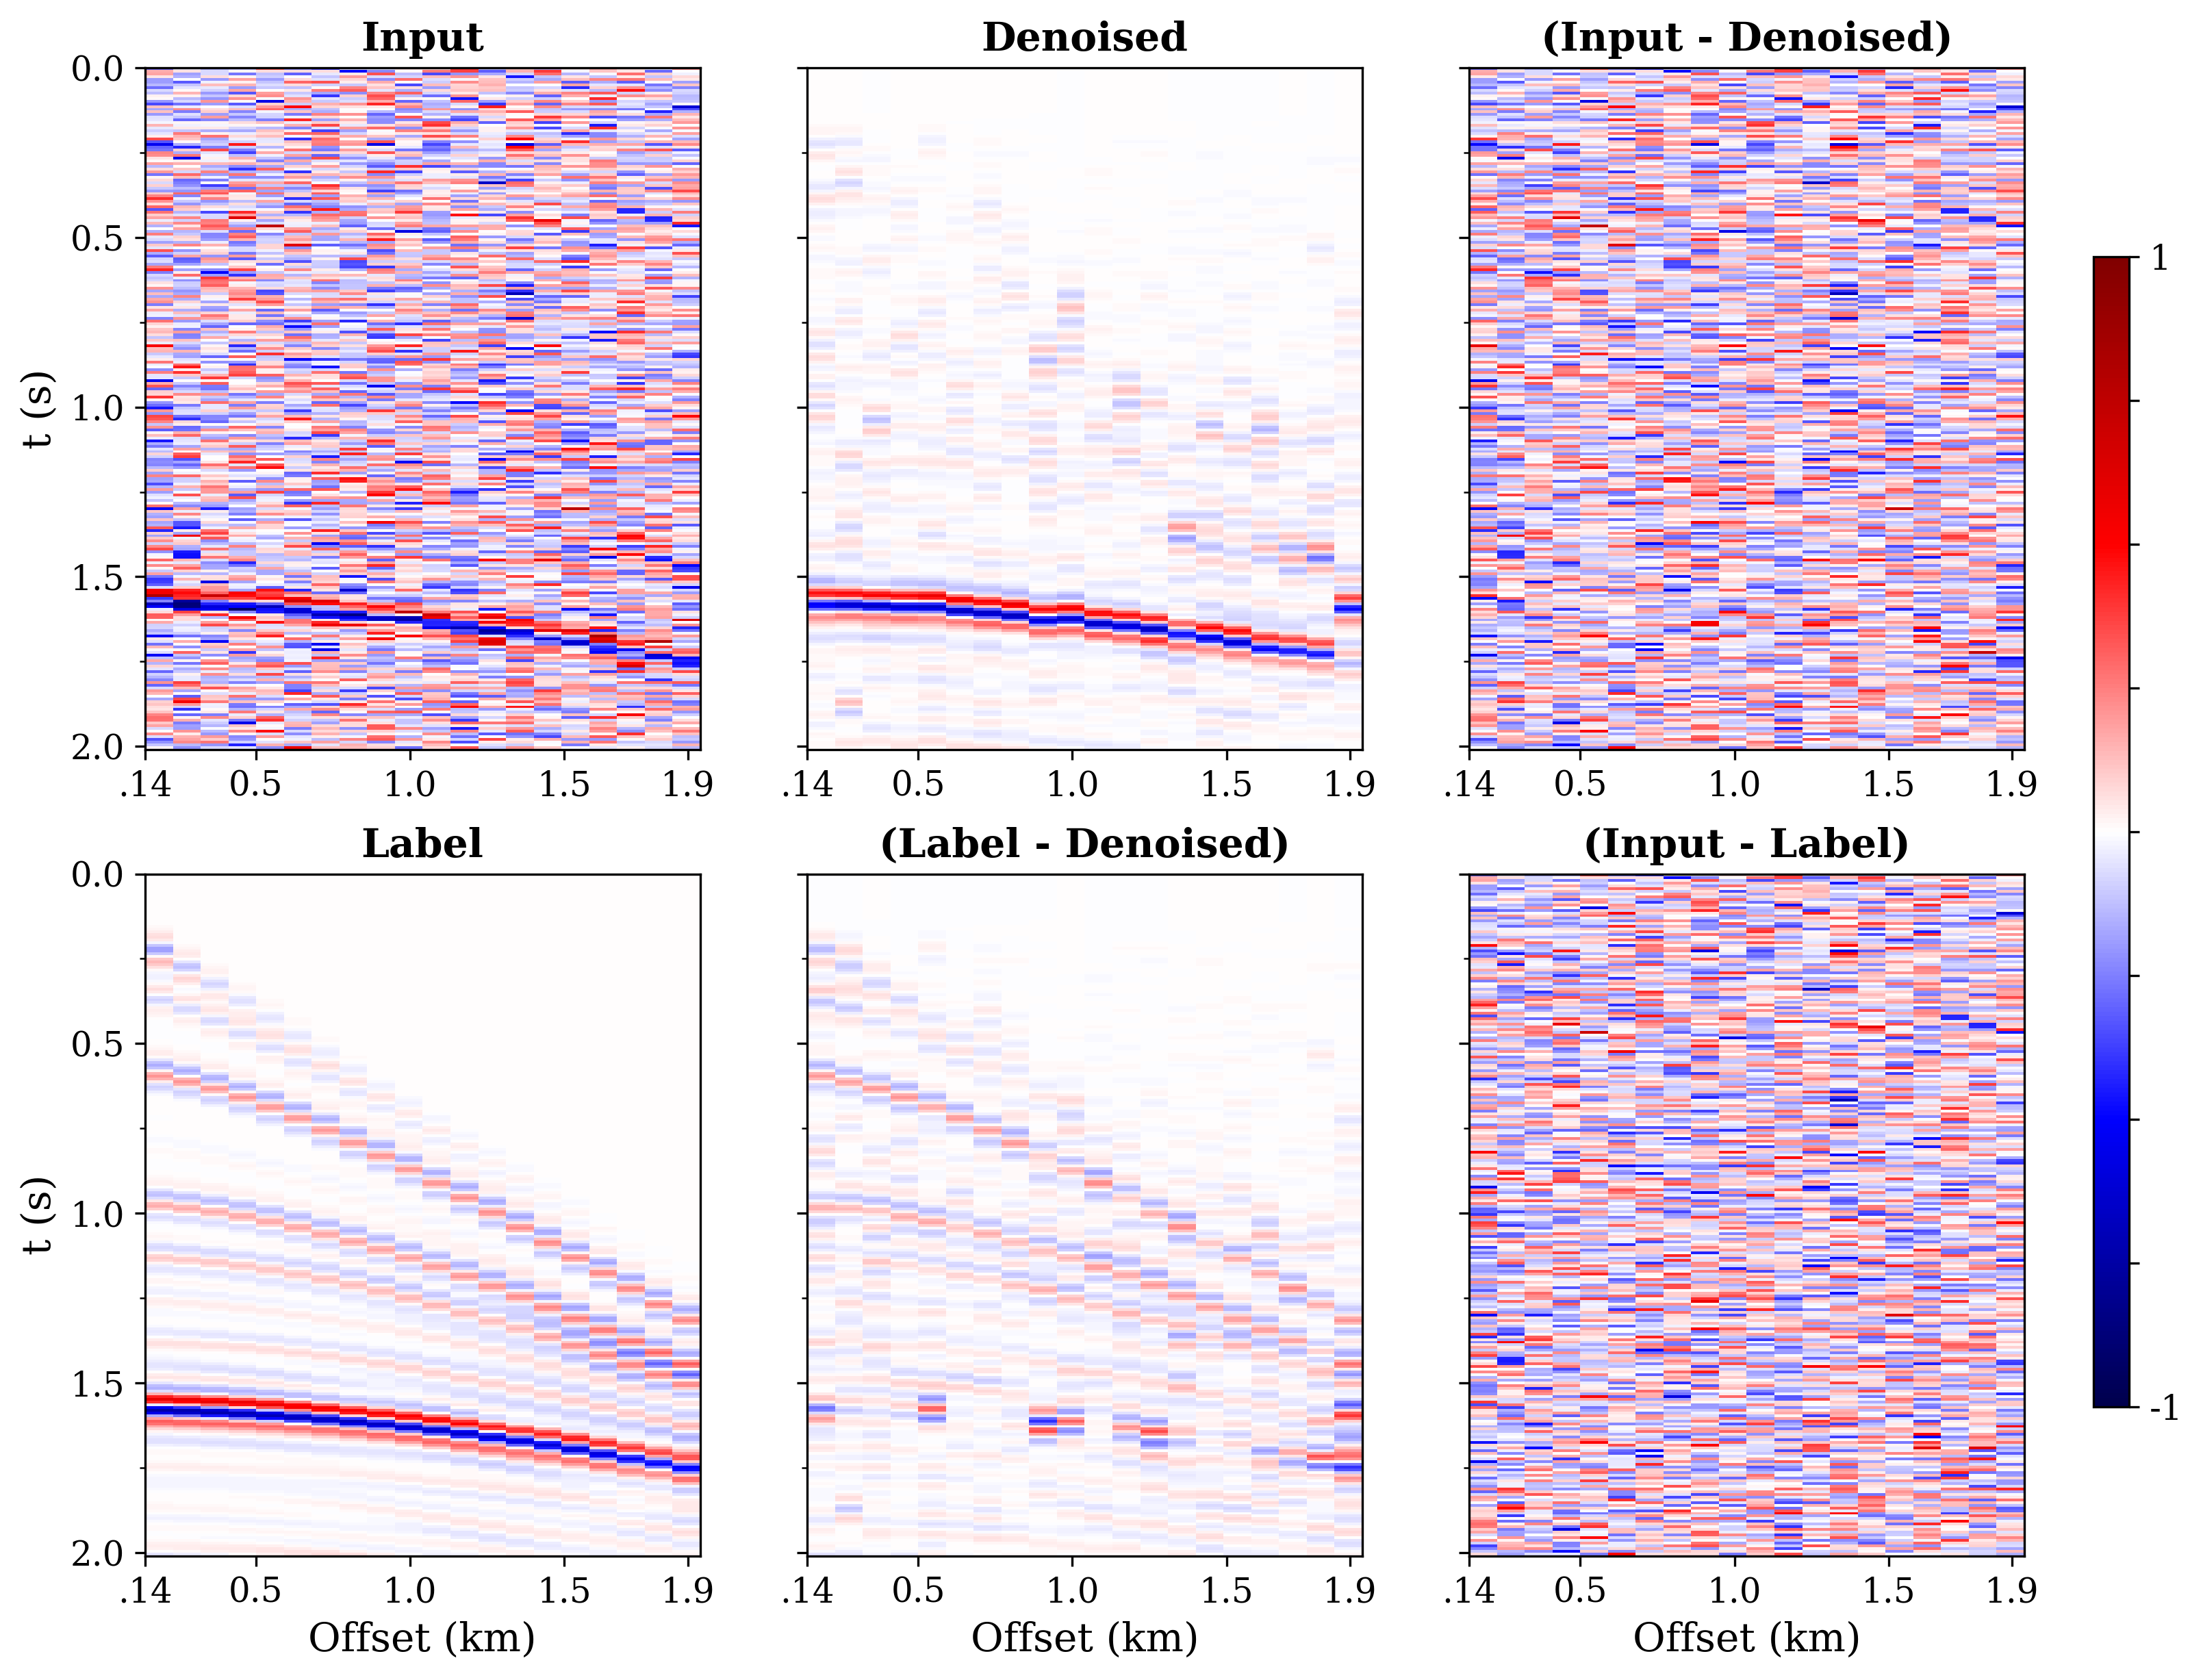

<IPython.core.display.Javascript object>

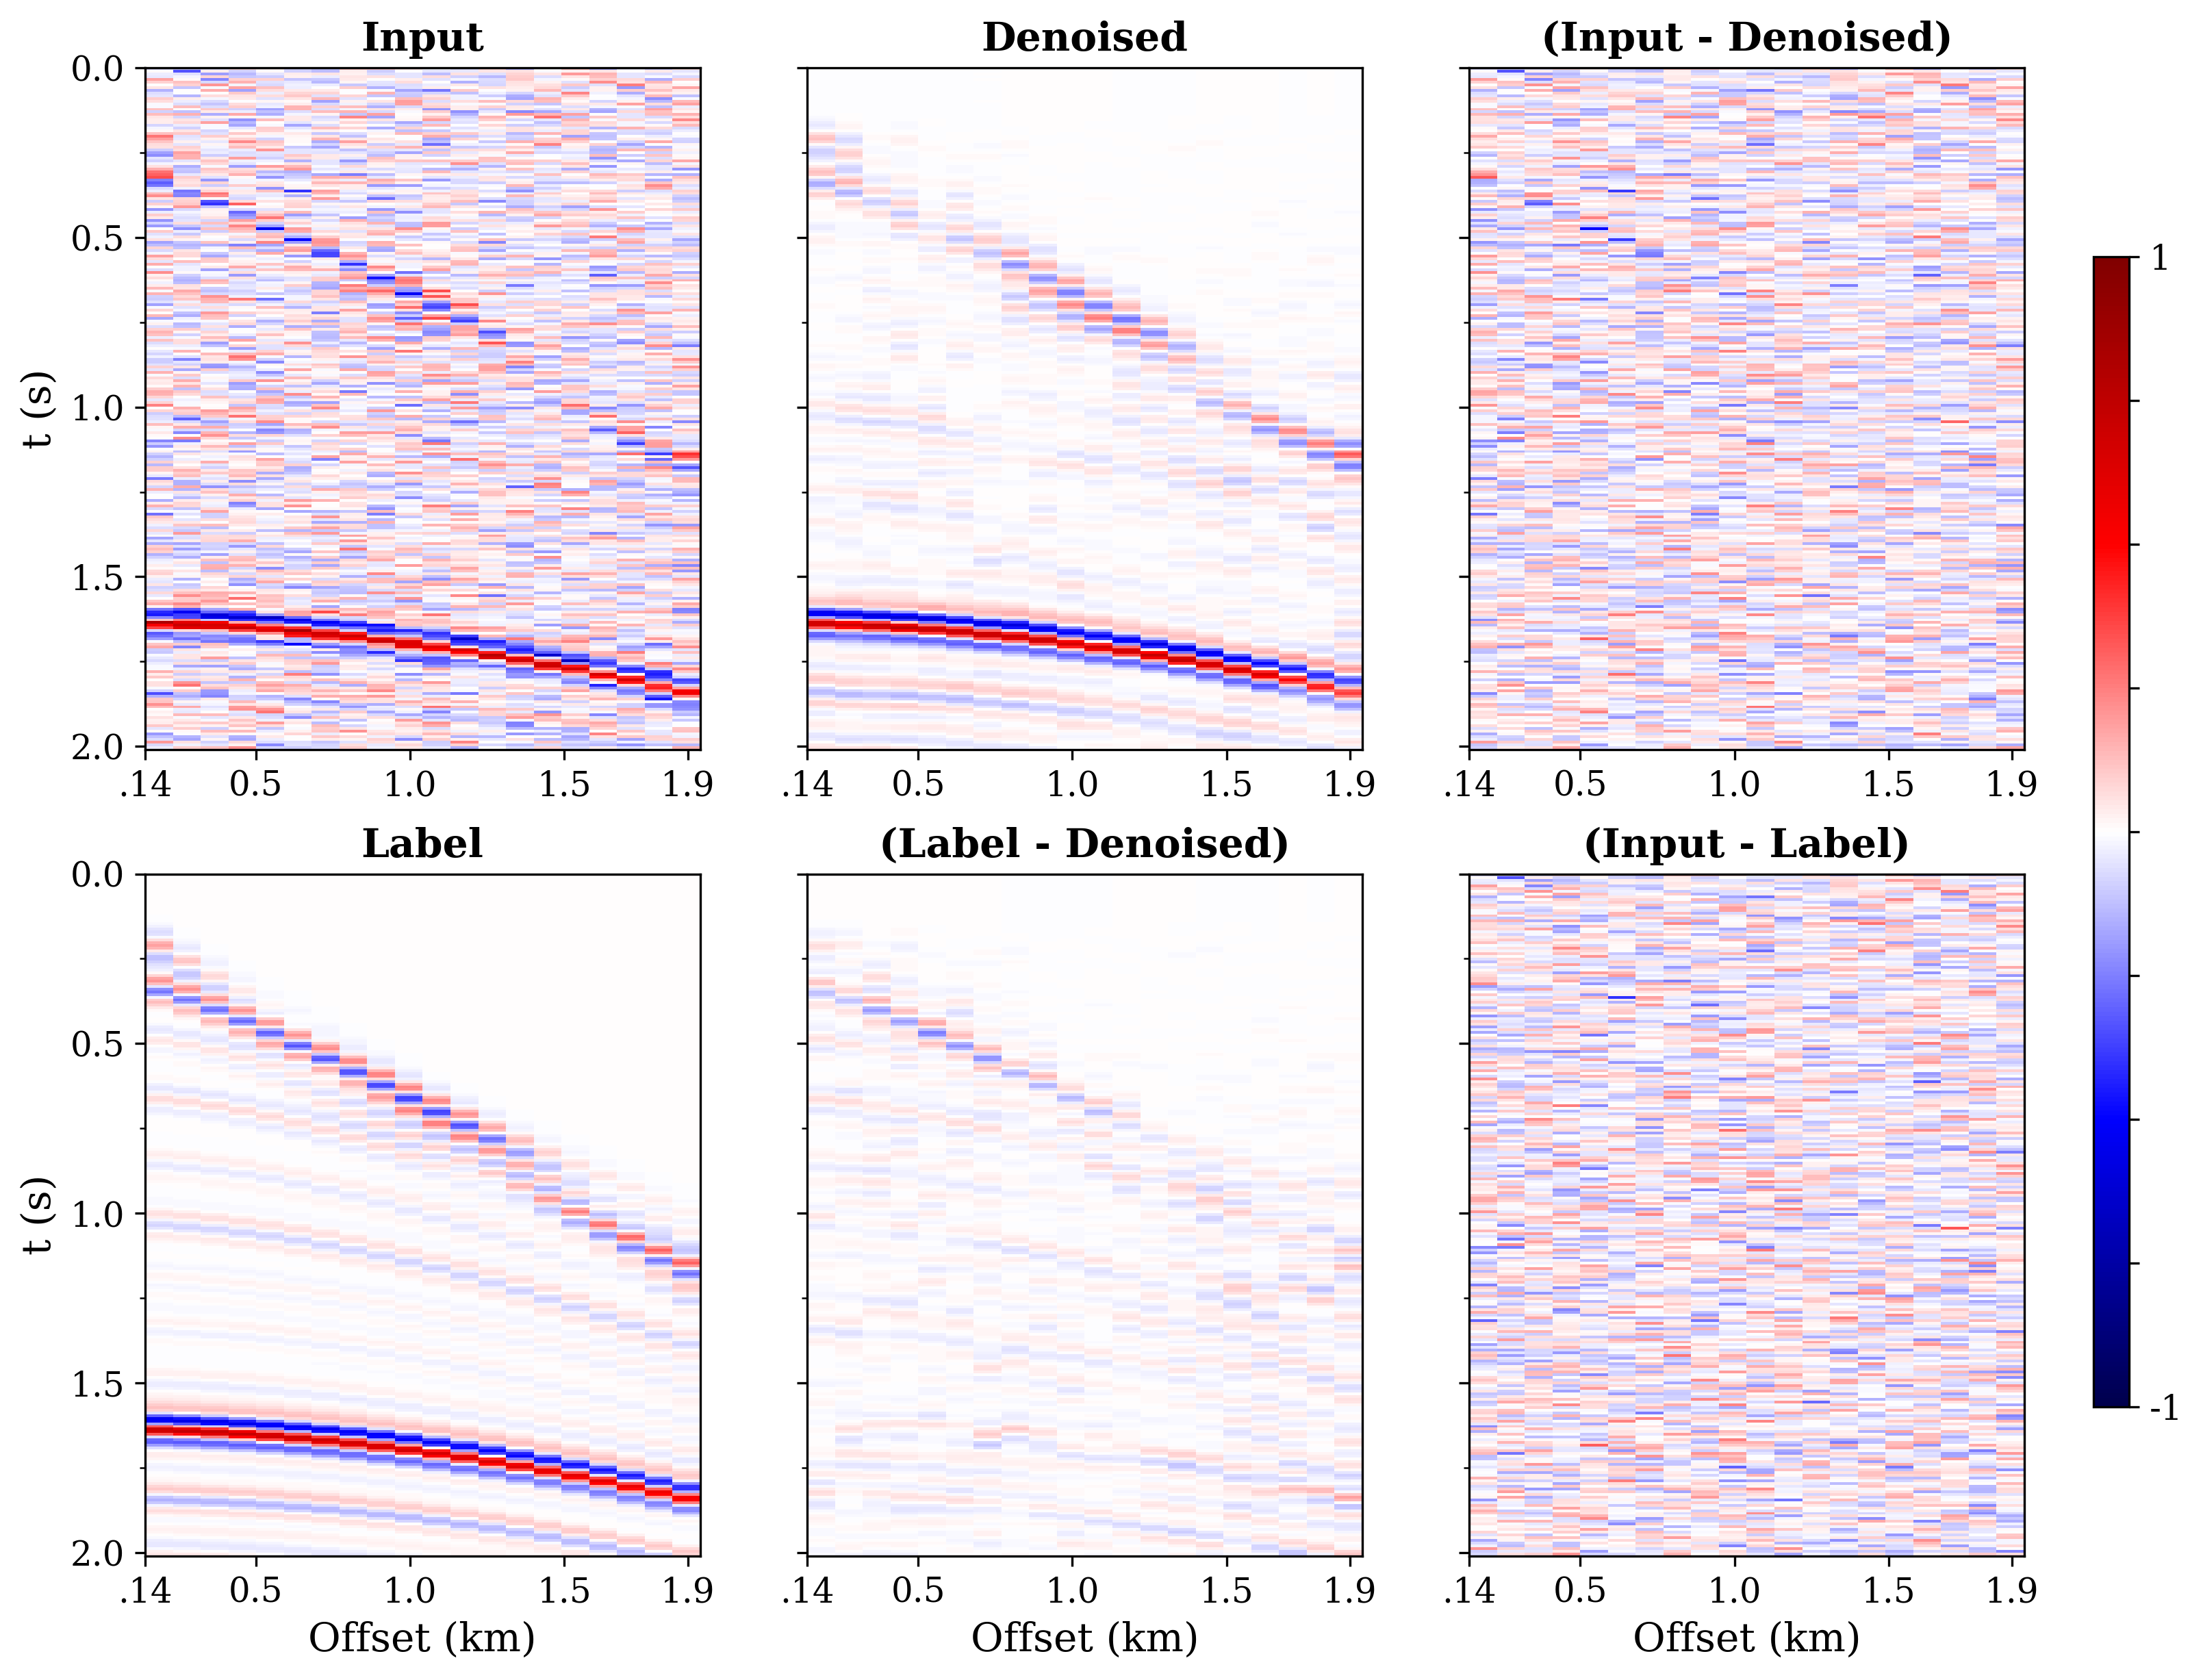

<IPython.core.display.Javascript object>

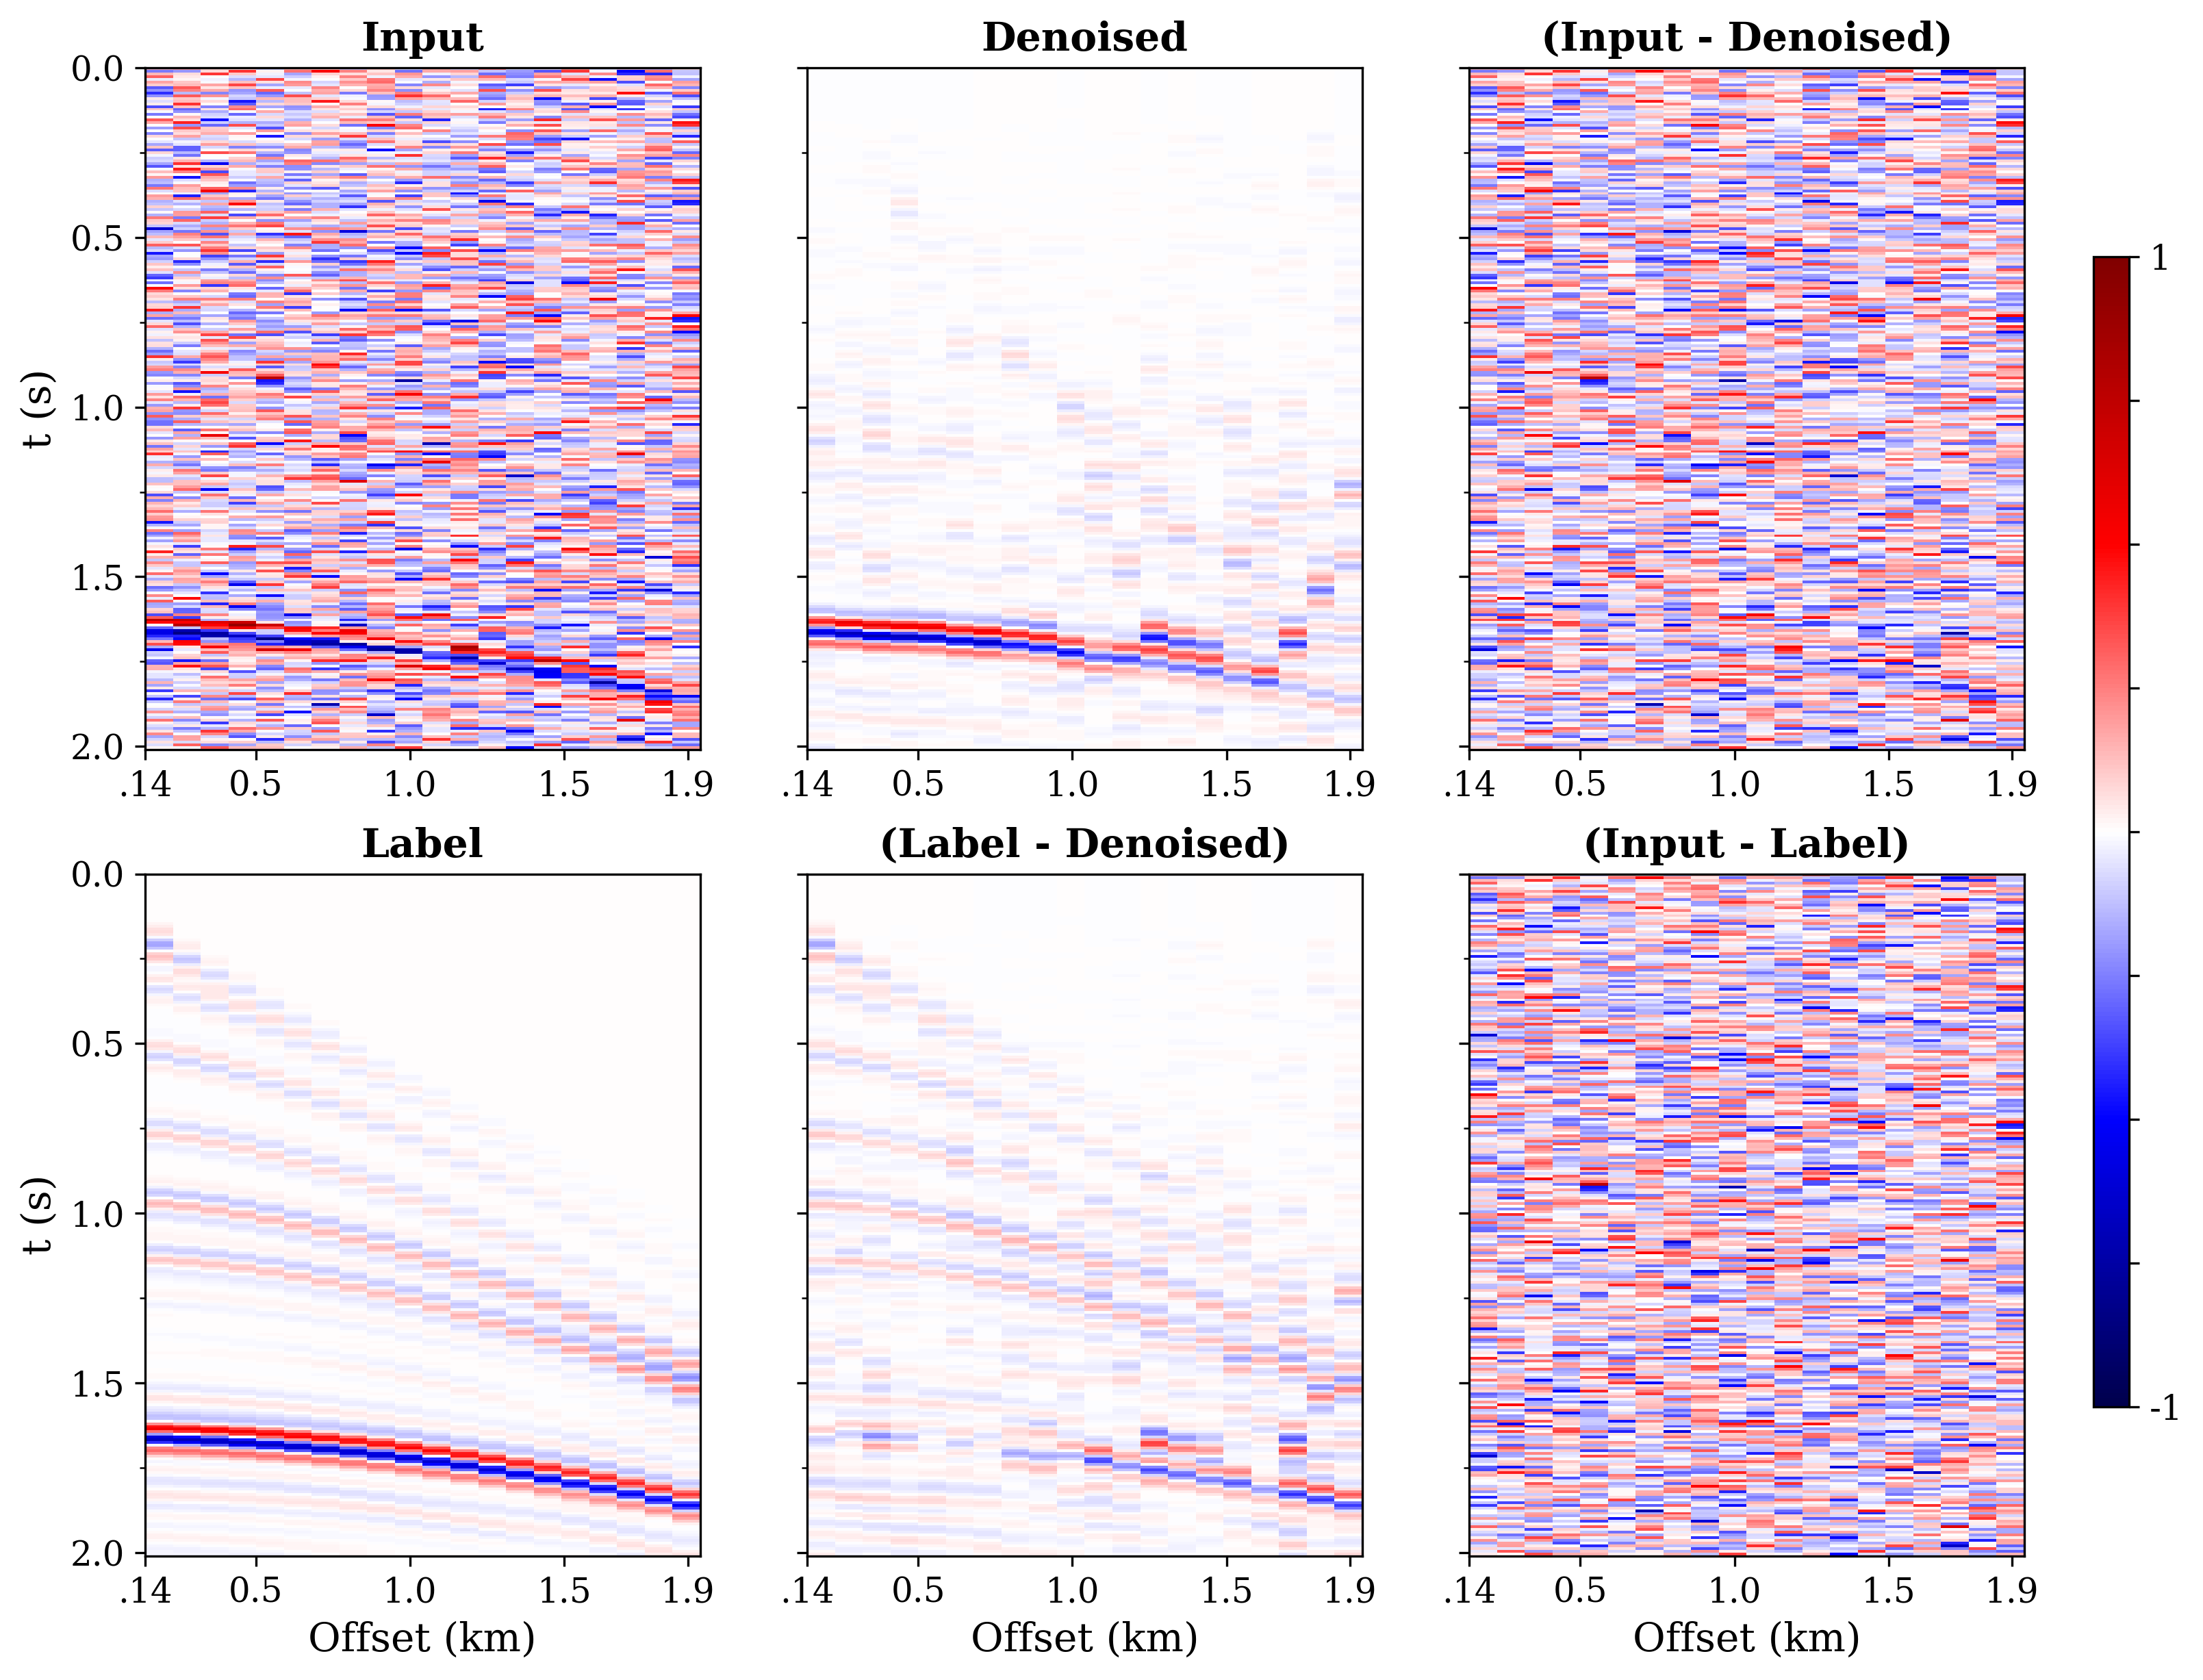

<IPython.core.display.Javascript object>

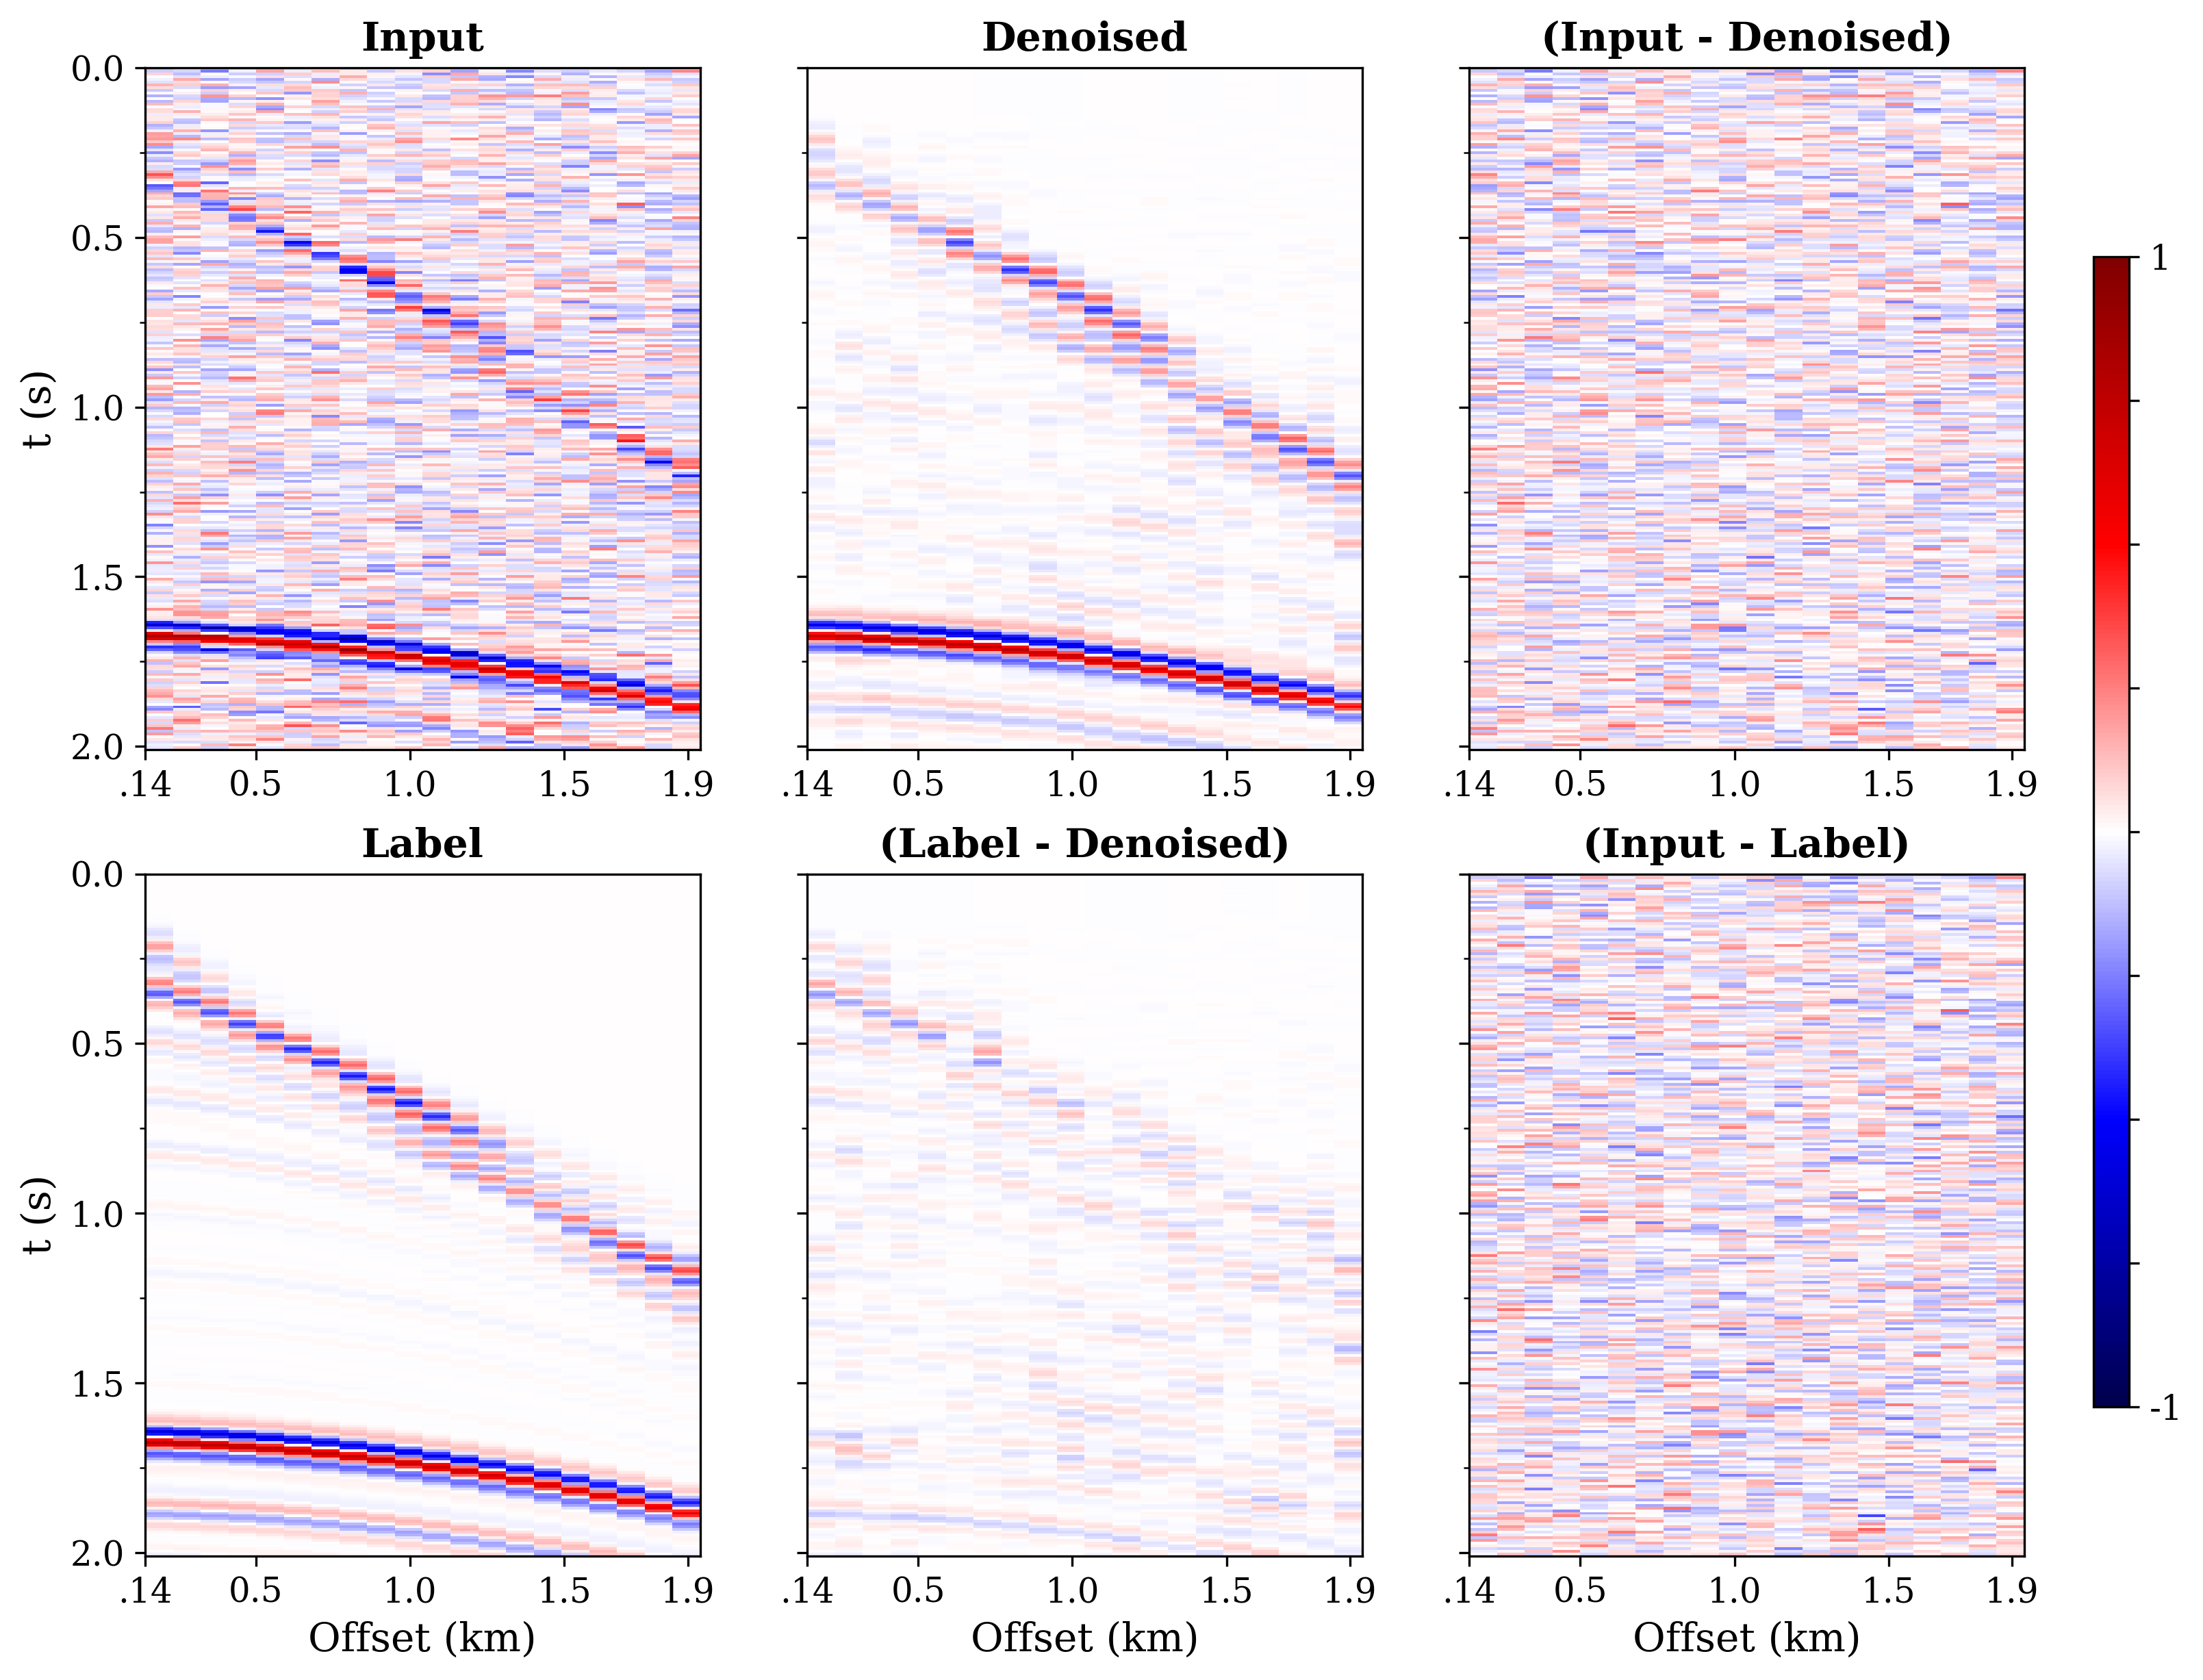

In [17]:
model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())

# Import for displaying images
from IPython.display import Image, display
import os

# Create a directory for saved plots if it doesn't exist
plot_dir = "denoising_plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

for i, (X, y, z) in enumerate(zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu())):
    # Create the plot as before
    f, ax = plt.subplots(2, 3, figsize=(10, 8), sharey=True, sharex=False)
    f.tight_layout()
    ax[0, 0].imshow(1 * (X - X.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', 
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0, 0].set_title("Input", fontsize=14)
    ax[0, 0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0, 0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0, 0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0, 0].set_ylabel("t (s)")
    ax[0, 1].imshow(1 * (y - y.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0, 1].set_title("Denoised", fontsize=14)
    ax[0, 1].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0, 1].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0, 1].set_yticks(np.arange(0, 2.5, 0.5))
    diff3 = 1 * (X - y)
    ax[0, 2].imshow((diff3 - diff3.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0, 2].set_title("(Input - Denoised)", fontsize=14)
    ax[0, 2].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0, 2].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0, 2].set_yticks(np.arange(0, 2.5, 0.5))
    diff1 = z
    ax[1, 0].imshow(1 * (diff1 - diff1.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1, 0].set_title("Label", fontsize=14)
    ax[1, 0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1, 0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1, 0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[1, 0].set_xlabel("Offset (km)")
    ax[1, 0].set_ylabel("t (s)")
    diff2 = 1 * (z - y)
    im4 = ax[1, 1].imshow((diff2 - diff2.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                         extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1, 1].set_title("(Label - Denoised)", fontsize=14)
    ax[1, 1].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1, 1].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1, 1].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1, 1].set_xlabel("Offset (km)")
    diff4 = 1 * (X - z)
    ax[1, 2].imshow((diff4 - diff4.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1, 2].set_title("(Input - Label)", fontsize=14)
    ax[1, 2].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1, 2].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1, 2].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1, 2].set_xlabel("Offset (km)")
    
    plt.ylim(2.01, 0)
    
    cbar_ax = f.add_axes([1, 0.15, 0.0175, 0.7])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])
    
    # Save the figure to a file
    file_path = os.path.join(plot_dir, f"denoising_result_{i}.png")
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    plt.close(f)  # Close the figure to free memory
    
    # Display the saved image in the notebook
    display(Image(filename=file_path))

In [18]:
# Define a more robust wrapper for the model that preserves the output structure
class ModelWithAdapter(nn.Module):
    def __init__(self, model, adapter):
        super().__init__()
        self.model = model
        self.adapter = adapter
        
    def forward(self, inputs_embeds=None, **kwargs):
        # Apply the adapter to the inputs
        if inputs_embeds is not None:
            adapted_inputs = self.adapter(inputs_embeds)
            # Call the original model with adapted inputs
            return self.model(inputs_embeds=adapted_inputs, **kwargs)
        return self.model(**kwargs)
        
    # Forward any attribute access to the wrapped model
    def __getattr__(self, name):
        if name == 'model' or name == 'adapter':
            return super().__getattr__(name)
        return getattr(self.model, name)

## Finalize

In [19]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/finetune/denoising/
Saving failed.
